# Merge the prophage counts based on the host's taxonomy

We are going to use the [GTDB](https://gtdb.ecogenomic.org/) taxonomy to count the number of prophages at different levels. Because of this, we merge with the GTDB metadata file.

In [1]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

import pandas as pd
import seaborn as sns
import numpy as np

import math
import re
import string

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA


In [17]:
phagesdf = read_phages(maxcontigs=-1)
phagesdf

Please note that this was run with git commit 86420e1 that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages,but after filtering we kept 3,265,453 prophages from 567,399 genomes

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...
567399,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
567400,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
567401,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
567402,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


### Read the data file

The metadata is from GTDB. The phage data is from us.


In [3]:
gtdb = read_gtdb()
gtdb

,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
0,GB_GCA_000006155.2,1916,93.12,0.00,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,...,NaN,NaN,NaN,NaN,NaN,NaN,42300,16,31,0
1,GB_GCA_000007385.1,0,99.82,0.00,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,...,1541.0,2846.0,0.0,100.000,JXEG01000201.4293.5839,Bacteria;Proteobacteria;Gammaproteobacteria;Xa...,0,20,53,0
2,GB_GCA_000008605.1,67,100.00,0.00,235,f__Spirochaetaceae (UID2512),124,0.0,1048744,92.155875,...,1545.0,2854.0,0.0,100.000,CP003679.231299.232859,Bacteria;Spirochaetes;Spirochaetia;Spirochaeta...,0,20,45,0
3,GB_GCA_000010565.1,0,100.00,0.63,295,p__Firmicutes (UID1022),158,0.0,2608397,86.217312,...,1526.0,2819.0,0.0,100.000,AP009389.1049070.1050595,Bacteria;Firmicutes;Clostridia;Clostridiales;P...,0,20,51,1
4,GB_GCA_000013845.2,0,100.00,0.00,332,o__Clostridiales (UID1375),124,0.0,2428396,82.037966,...,1509.0,2787.0,0.0,100.000,CP000312.233320.234832,Bacteria;Firmicutes;Clostridia;Clostridiales;C...,0,20,95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,RS_GCF_902166935.1,0,99.62,0.09,1312,g__Klebsiella (UID5140),336,0.0,4894244,87.293148,...,1536.0,2837.0,0.0,100.000,MAPL01000082.143.1696,Bacteria;Proteobacteria;Gammaproteobacteria;En...,0,20,87,1
191523,RS_GCF_902166945.1,0,99.94,0.72,1162,f__Enterobacteriaceae (UID5121),336,0.0,5162721,86.540042,...,1536.0,2837.0,0.0,100.000,CP016813.16076.17629,Bacteria;Proteobacteria;Gammaproteobacteria;En...,0,20,86,1
191524,RS_GCF_902167295.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5737447,90.122088,...,1490.0,2747.0,0.0,99.933,JX101438.1.1490,Bacteria;Bacteroidetes;Bacteroidia;Chitinophag...,0,20,58,0
191525,RS_GCF_902167305.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5738096,90.147873,...,1490.0,2747.0,0.0,99.933,JX101438.1.1490,Bacteria;Bacteroidetes;Bacteroidia;Chitinophag...,0,20,58,0


### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [4]:
acccol = 'assembly_accession'

## Sanity check

This is just to make sure that we are all working on the same data. Here, we make a temporary data frame that has the number of contigs and the number of basepairs in the genome, and use those to compare to see if we think we are working on the same thing.

If we find columns that are no good, we should delete them (but we don't, yay!)

In [5]:
def are_same(x):
    # currently fixing contig counts, so when that is done delete the next line and uncomment the one after
    return x['genome_size'] == x['Genome length']
    # return x['genome_size'] == x['Genome length'] and x['contig_count'] == x['Contigs']

comparison = pd.merge(gtdb[[acccol, 'contig_count', 'genome_size']],
                      phagesdf[[acccol, 'Contigs', 'Genome length']],
                      how='inner', left_on=acccol, right_on=acccol)

comparison['same'] = comparison.apply(are_same, axis=1)
# look for rows that are not the same
comparison[comparison['same']==False]

,assembly_accession,contig_count,genome_size,Contigs,Genome length,same


## Filter the genomes

We should probably filter out based on quality. We have three quality scores (mimag high/medium/low) plus the number of contigs. Lets make a little violin plot of the quality vs Total or Kept prophages.


In [18]:
qual = pd.merge(gtdb[[acccol, 'checkm_completeness', 'gc_percentage', 'contig_count', 'genome_size', 'mimag_high_quality', 'mimag_low_quality', 'mimag_medium_quality']],
                phagesdf[[acccol, 'Total Predicted Prophages', 'Kept']],
                how='inner', left_on=acccol, right_on=acccol)
qual

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept
0,GCA_000006155.2,93.12,35.101404,426,5370060,f,f,t,5.0,0.0
1,GCA_000007385.1,99.82,63.693289,1,4941439,t,f,f,29.0,4.0
2,GCA_000008605.1,100.00,52.775181,1,1138011,t,f,f,5.0,1.0
3,GCA_000010565.1,100.00,52.961104,1,3025375,t,f,f,25.0,2.0
4,GCA_000013845.2,100.00,28.230917,4,2960088,t,f,f,12.0,2.0
...,...,...,...,...,...,...,...,...,...,...
126124,GCA_902158665.1,100.00,55.252894,23,6052172,t,f,f,29.0,0.0
126125,GCA_902158685.1,100.00,55.244893,38,6020052,t,f,f,27.0,2.0
126126,GCA_902158695.1,100.00,55.248393,59,6071600,t,f,f,27.0,5.0
126127,GCA_902158715.1,100.00,54.639170,65,6393461,t,f,f,31.0,1.0


In [19]:
def mimag_qual(x):
    if x['mimag_high_quality'] == 't':
        return "High"
    if x['mimag_medium_quality'] == 't':
        return "Medium"
    if x['mimag_low_quality'] == 't':
        return "Low"
    return "Unknown"

qual['Mimag quality'] = qual.apply(mimag_qual, axis=1)
qual

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept,Mimag quality
0,GCA_000006155.2,93.12,35.101404,426,5370060,f,f,t,5.0,0.0,Medium
1,GCA_000007385.1,99.82,63.693289,1,4941439,t,f,f,29.0,4.0,High
2,GCA_000008605.1,100.00,52.775181,1,1138011,t,f,f,5.0,1.0,High
3,GCA_000010565.1,100.00,52.961104,1,3025375,t,f,f,25.0,2.0,High
4,GCA_000013845.2,100.00,28.230917,4,2960088,t,f,f,12.0,2.0,High
...,...,...,...,...,...,...,...,...,...,...,...
126124,GCA_902158665.1,100.00,55.252894,23,6052172,t,f,f,29.0,0.0,High
126125,GCA_902158685.1,100.00,55.244893,38,6020052,t,f,f,27.0,2.0,High
126126,GCA_902158695.1,100.00,55.248393,59,6071600,t,f,f,27.0,5.0,High
126127,GCA_902158715.1,100.00,54.639170,65,6393461,t,f,f,31.0,1.0,High


## How many genomes are low quality

In [25]:
print(f"There are {gtdb[gtdb['mimag_low_quality']=='t'].shape[0]} low quality genomes in GTDB")
print(f"There are {qual[qual['Mimag quality'] == 'Low'].shape[0]} low quality genomes in qual")

There are 17 low quality genomes in GTDB
There are 15 low quality genomes in qual


In [29]:
print(f"There are {gtdb.shape[0]:,} genomes in GTDB and {phagesdf.shape[0]:,} genomes in phages, but {qual.shape[0]:,} genomes in both")

There are 191,527 genomes in GTDB and 567,399 genomes in phages, but 126,129 genomes in both


In [32]:
qual.groupby('Mimag quality').agg('size')

Mimag quality
High       73023
Low           15
Medium     52953
Unknown      138
dtype: int64

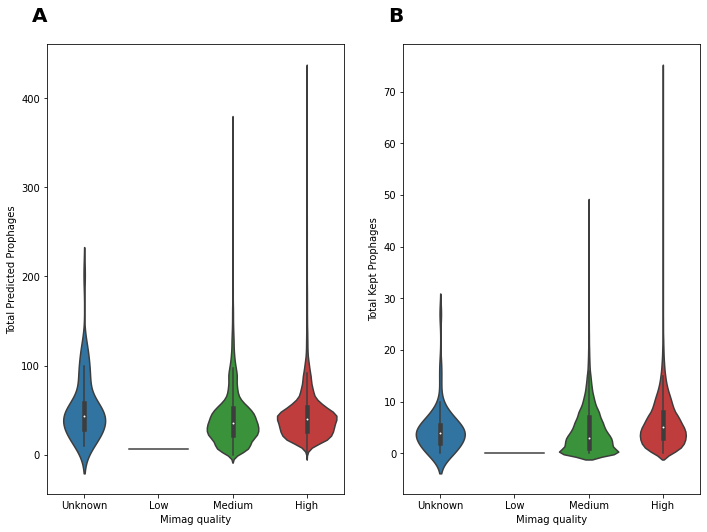

In [8]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.violinplot(x='Mimag quality', y='Total Predicted Prophages', jitter=True, data=qual, ax=ax[0], order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Total Predicted Prophages',  jitter=True, data=qual, alpha=0.1, ax=ax[0], color='k')

sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax[1], order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax[1])
ax[1].set_ylabel("Total Kept Prophages")

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

plt.show()


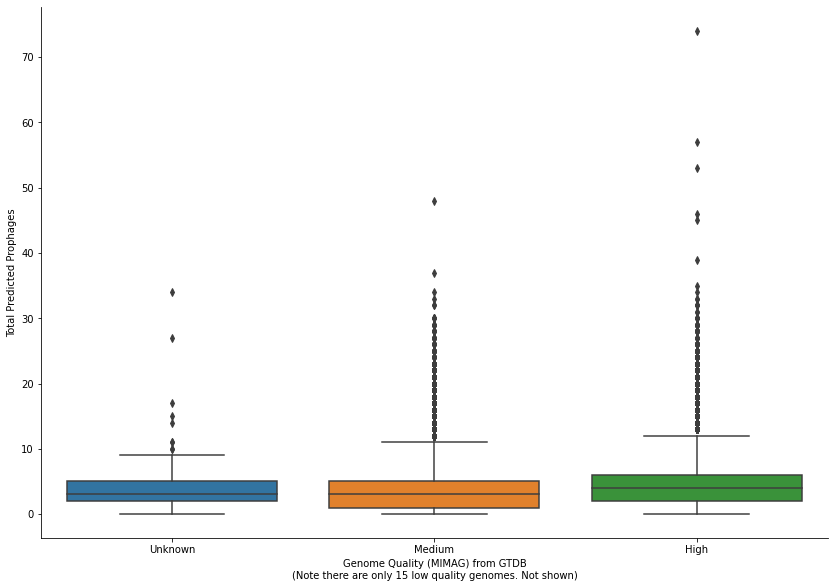

In [40]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

#sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax, order=['Unknown', 'Medium', 'High'])
sns.boxplot(x='Mimag quality', y='Kept', data=qual, ax=ax, order=['Unknown', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax)
ax.set_ylabel("Total Predicted Prophages")
xt="Genome Quality (MIMAG) from GTDB\n(Note there are only 15 low quality genomes. Not shown)"
ax.set_xlabel(xt)


ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tight_layout()

fig.savefig('images/mimag_phages_box.png')
fig.savefig('images/mimag_phages_box.svg')

plt.show()

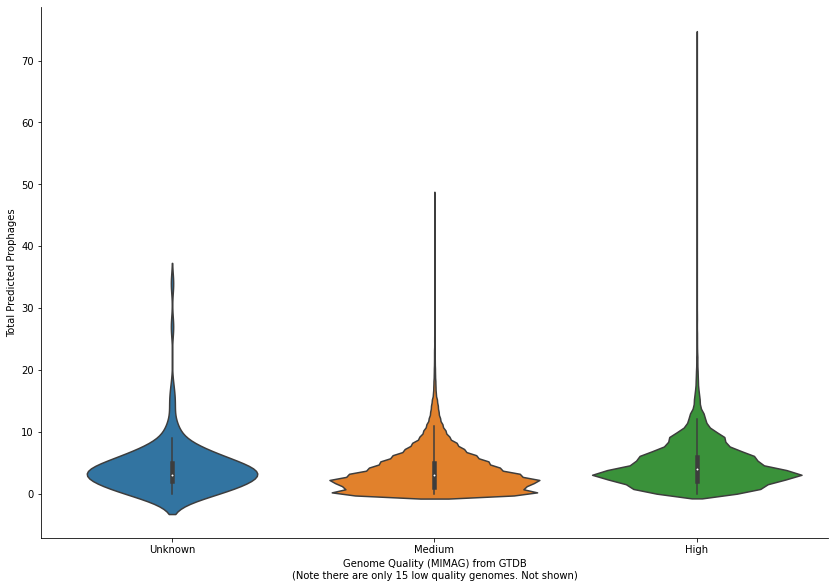

In [39]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax, order=['Unknown', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax)
ax.set_ylabel("Total Predicted Prophages")
xt="Genome Quality (MIMAG) from GTDB\n(Note there are only 15 low quality genomes. Not shown)"
ax.set_xlabel(xt)


ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tight_layout()

fig.savefig('images/mimag_phages_violin.png')
fig.savefig('images/mimag_phages_violin.svg')

plt.show()

### How does completeness/size compare with predictions?

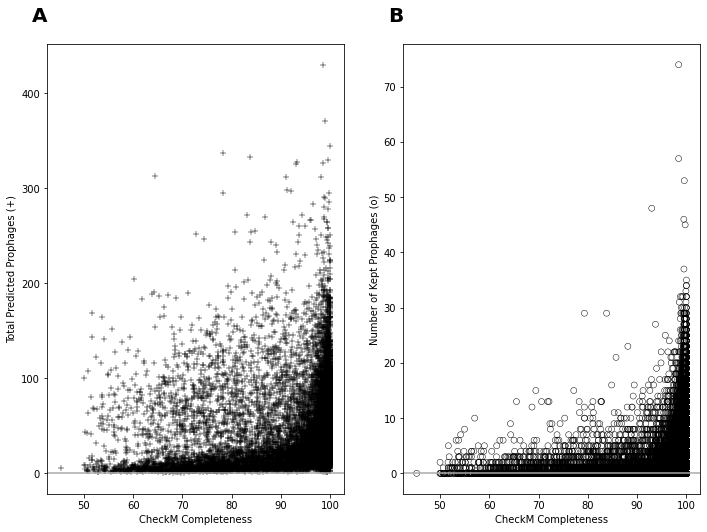

In [10]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='checkm_completeness', y='Total Predicted Prophages', data=qual, marker='+', color='k', ax=ax[0])
sns.scatterplot(x='checkm_completeness', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
# ax2.grid(False)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('CheckM Completeness')
ax[1].set_xlabel('CheckM Completeness')
ax[0].axhline(y=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

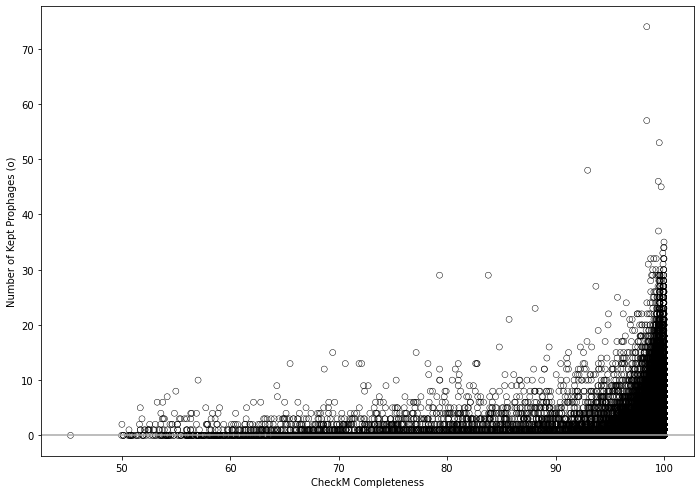

In [11]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.scatterplot(x='checkm_completeness', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax)
ax.set_ylabel('Number of Kept Prophages (o)')
ax.set_xlabel('CheckM Completeness')
ax.axhline(y=0, color='darkgrey')

fig.savefig("images/checkm_vs_phages.svg")

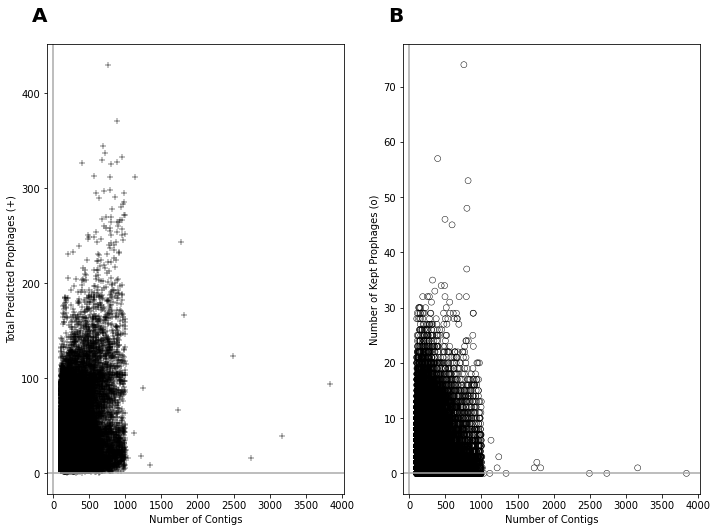

In [12]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])

ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/contigs_vs_phages.svg")


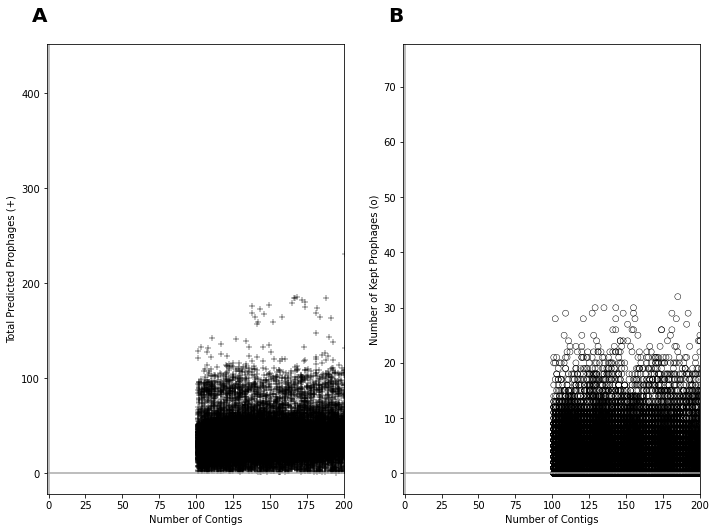

In [13]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
ax[0].set_xlim(-1,200)
ax[1].set_xlim(-1,200)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')


for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/contigs_vs_phages_0200.svg")

At the moment there doesn't seem to be an obvious reason to cut or cull any of these predictions!

# Compare CheckM and CheckV

See if high/medium/low phage genomes correlate with other predictions?

See the `checkv` workbook on how to do this... needs abstracting to a method DO NOT COPY THIS!

In [44]:
checkv = read_checkv()
base_pp = read_base_pp()
checkvb = pd.merge(base_pp, checkv, on='Prophage', how='inner')
acv = checkvb.groupby(['assembly_accession', 'checkv_quality']).agg({'checkv_quality': 'size'})
acvr = acv.rename({'checkv_quality':'checkv_count'}, axis=1).reset_index()
tmp = acvr[acvr['checkv_quality'] == 'Not-determined'][['assembly_accession', 'checkv_count']].rename({'checkv_count' : 'Not-determined'}, axis=1)
for t in ['Low-quality', 'Medium-quality', 'High-quality', 'Complete']:
    tmp2 = acvr[acvr['checkv_quality'] == t][['assembly_accession', 'checkv_count']].rename({'checkv_count' : t}, axis=1)
    tmp = pd.merge(tmp, tmp2, on='assembly_accession', how='outer')
checkvcounts = tmp.fillna(0)
checkvcounts

,assembly_accession,Not-determined,Low-quality,Medium-quality,High-quality,Complete
0,GCA_000003135.1,1.0,1.0,0.0,0.0,0.0
1,GCA_000003925.1,2.0,2.0,1.0,1.0,0.0
2,GCA_000005825.2,2.0,1.0,0.0,0.0,0.0
3,GCA_000006625.1,1.0,1.0,0.0,0.0,0.0
4,GCA_000006965.1,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
520147,GCA_901305565.1,0.0,0.0,0.0,0.0,1.0
520148,GCA_901319165.1,0.0,0.0,0.0,0.0,1.0
520149,GCA_901325505.1,0.0,0.0,0.0,0.0,1.0
520150,GCA_901331095.1,0.0,0.0,0.0,0.0,1.0


In [63]:
checkmv = pd.merge(qual[['assembly_accession', 'checkm_completeness', 'Kept', 'Mimag quality']], checkvcounts, on='assembly_accession', how='inner')
checkmv['checkm_round'] = round(checkmv['checkm_completeness'],0)
checkmv

,assembly_accession,checkm_completeness,Kept,Mimag quality,Not-determined,Low-quality,Medium-quality,High-quality,Complete,checkm_round
0,GCA_000007385.1,99.82,4.0,High,2.0,1.0,1.0,0.0,0.0,100.0
1,GCA_000008605.1,100.00,1.0,High,0.0,1.0,0.0,0.0,0.0,100.0
2,GCA_000010565.1,100.00,2.0,High,1.0,0.0,0.0,1.0,0.0,100.0
3,GCA_000013845.2,100.00,2.0,High,1.0,0.0,1.0,0.0,0.0,100.0
4,GCA_000014305.1,97.38,4.0,High,3.0,1.0,0.0,0.0,0.0,97.0
...,...,...,...,...,...,...,...,...,...,...
113141,GCA_902158655.1,100.00,4.0,High,0.0,1.0,1.0,2.0,0.0,100.0
113142,GCA_902158685.1,100.00,2.0,High,0.0,0.0,1.0,1.0,0.0,100.0
113143,GCA_902158695.1,100.00,5.0,High,1.0,0.0,1.0,3.0,0.0,100.0
113144,GCA_902158715.1,100.00,1.0,High,0.0,1.0,0.0,0.0,0.0,100.0


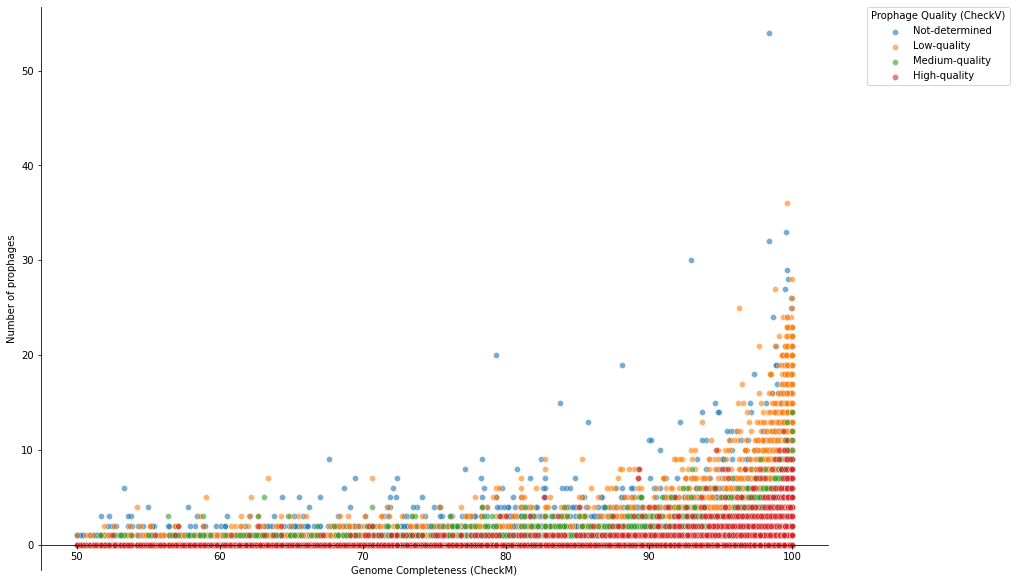

In [68]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    sns.scatterplot(x='checkm_completeness', y=c, data=checkmv, marker='o', ax=ax, label=c, alpha=0.6)

#sns.lineplot(x='checkm_round', y='Kept', data=checkmv, color='k', ax=ax, label='All predictions', alpha=0.6)

ax.set_ylabel('Number of prophages')
ax.set_xlabel('Genome Completeness (CheckM)')
ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(title="Prophage Quality (CheckV)", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig('images/checkm_checkv.png')
fig.savefig('images/checkm_checkv.svg')


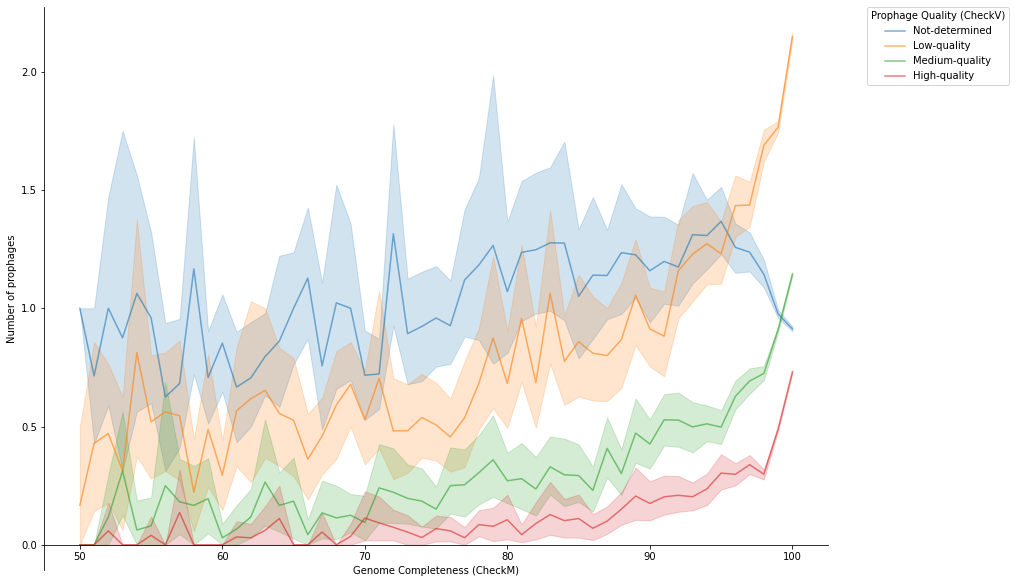

In [67]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    sns.lineplot(x='checkm_round', y=c, data=checkmv, ax=ax, label=c, alpha=0.6)

#ax2 = ax.twinx()
sns.lineplot(x='checkm_round', y='Kept', data=checkmv, color='k', ax=ax2, label='All predictions', alpha=0.6)

ax.set_ylabel('Number of prophages')
ax.set_xlabel('Genome Completeness (CheckM)')
ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
l.set_title("Prophage Quality (CheckV)")

# Taxonomy

Extract the taxonomy from the GTDB table

### Split the taxonomy into separate columns

We split on `_` but unfortunately the `_` means something specific in GTDB. This is taken from the [FAQ](https://gtdb.ecogenomic.org/faq)
> If the organism had been assigned a binomial species name such as Prevotella oralitaxus str. F0040, and it is not part of true Prevotella in GTDB, we would assign it to the placeholder genus g__Prevotella_A to indicate it is not a true Prevotella species, but that there are representative genomes that have been assigned to a species

We at least remove the `g__` at the beginning and then leave the appendages.

In [69]:
s = re.compile('^.__')
# u = re.compile('_')
def split_taxonomy(x):
    p  = x.split(';')
    if len(p) != 7:
        sys.stderr.write("We have {len(p)} fields in {x}, but we expected 7 fields")
    # remove the prepended taxonomic rank name (e.g d__) and any remaining underscores before returning.
    # return [u.sub(' ', l) for l in [s.sub('', m) for m in p] ]
    return [s.sub('', m) for m in p]

In [70]:
# this is an example to make sure the split looks good. Returns an array
split_taxonomy(gtdb['gtdb_taxonomy'].iloc[0])

['Bacteria',
 'Firmicutes',
 'Bacilli',
 'Bacillales',
 'Bacillaceae_G',
 'Bacillus_A',
 'Bacillus_A anthracis']

In [71]:
tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gc = ['accession', 'gtdb_genome_representative', 'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation', 'gtdb_type_designation_sources', 'gtdb_type_species_of_genus']
gtdbex = pd.concat([gtdb[acccol], pd.DataFrame.from_records(gtdb['gtdb_taxonomy'].apply(split_taxonomy), columns=tc), gtdb[gc]], axis=1)
gtdbex

,assembly_accession,domain,phylum,class,order,family,genus,species,accession,gtdb_genome_representative,gtdb_representative,gtdb_taxonomy,gtdb_type_designation,gtdb_type_designation_sources,gtdb_type_species_of_genus
0,GCA_000006155.2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae_G,Bacillus_A,Bacillus_A anthracis,GB_GCA_000006155.2,RS_GCF_000534935.2,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,not type material,NaN,f
1,GCA_000007385.1,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,GB_GCA_000007385.1,RS_GCF_004136375.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
2,GCA_000008605.1,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum,GB_GCA_000008605.1,RS_GCF_000410535.2,f,d__Bacteria;p__Spirochaetota;c__Spirochaetia;o...,not type material,NaN,f
3,GCA_000010565.1,Bacteria,Firmicutes_B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum,GB_GCA_000010565.1,GB_GCA_000010565.1,t,d__Bacteria;p__Firmicutes_B;c__Desulfotomaculi...,type strain of species,LPSN; DSMZ; StrainInfo,t
4,GCA_000013845.2,Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium_P,Clostridium_P perfringens,GB_GCA_000013845.2,RS_GCF_000013285.1,f,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__C...,not type material,NaN,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,GCA_902166935.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae,RS_GCF_902166935.1,RS_GCF_000742135.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
191523,GCA_902166945.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae,RS_GCF_902166945.1,RS_GCF_000742135.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
191524,GCA_902167295.1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis_A,RS_GCF_902167295.1,RS_GCF_902167325.1,f,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,NaN,f
191525,GCA_902167305.1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis_A,RS_GCF_902167305.1,RS_GCF_902167325.1,f,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,NaN,f


### Do we need to combine to different levels

We can combined e.g. from Bacteria to Order. But do we need to?

In [72]:
toorder = len(pd.unique(gtdbex.apply(lambda x: '_'.join(x[1:5].values.tolist()), axis=1)))
uniqueorder = len(pd.unique(gtdbex['order']))
print(f"Unique orders: {uniqueorder} Unique to order: {toorder}")

Unique orders: 930 Unique to order: 930


[According to Donovan, they should be unique](https://forum.gtdb.ecogenomic.org/t/uniqueness-of-names-across-the-taxonomy/137) so we don't need to merge the columns! 

## Merge the data frames

Merge the GTDB taxonomy with the prophage counts into a single df

In [73]:
cvtax = pd.merge(gtdbex[['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']], checkvcounts, left_on='assembly_accession', right_on='assembly_accession', how='inner')
cvtax = pd.merge(cvtax, phagesdf[['assembly_accession', 'Kept']], left_on='assembly_accession', right_on='assembly_accession', how='inner')
cvtax

,assembly_accession,domain,phylum,class,order,family,genus,species,Not-determined,Low-quality,Medium-quality,High-quality,Complete,Kept
0,GCA_000007385.1,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,2.0,1.0,1.0,0.0,0.0,4.0
1,GCA_000008605.1,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum,0.0,1.0,0.0,0.0,0.0,1.0
2,GCA_000010565.1,Bacteria,Firmicutes_B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum,1.0,0.0,0.0,1.0,0.0,2.0
3,GCA_000013845.2,Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium_P,Clostridium_P perfringens,1.0,0.0,1.0,0.0,0.0,2.0
4,GCA_000014305.1,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus suis,3.0,1.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113141,GCA_902158655.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella_A,Klebsiella_A grimontii,0.0,1.0,1.0,2.0,0.0,4.0
113142,GCA_902158685.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella_A,Klebsiella_A grimontii,0.0,0.0,1.0,1.0,0.0,2.0
113143,GCA_902158695.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella_A,Klebsiella_A grimontii,1.0,0.0,1.0,3.0,0.0,5.0
113144,GCA_902158715.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella_A,Klebsiella_A grimontii,0.0,1.0,0.0,0.0,0.0,1.0


In [74]:
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    print(cvtax[c].mean())

0.9524243013451646
1.97900058331713
1.033867746097962
0.6275785268591024


### Make a plot

This makes a plot of the data, and sets the labels to be readable.

In [110]:
phsum = cvtax.groupby('phylum').agg('sum').reset_index()
phsum.sort_values(ascending=False, by='Kept')

,phylum,Not-determined,Low-quality,Medium-quality,High-quality,Complete,Kept
72,Proteobacteria,54638.0,151637.0,72169.0,45173.0,2713.0,337491.0
41,Firmicutes,20987.0,41184.0,33521.0,21347.0,754.0,118819.0
5,Actinobacteriota,16664.0,16205.0,4254.0,1979.0,135.0,41806.0
42,Firmicutes_A,6054.0,7876.0,4354.0,1674.0,149.0,20296.0
10,Bacteroidota,4154.0,3272.0,1168.0,377.0,3.0,9339.0
...,...,...,...,...,...,...,...
79,Sumerlaeota,0.0,1.0,0.0,0.0,0.0,1.0
50,GCA-001730085,1.0,0.0,0.0,0.0,0.0,1.0
2,ARS69,1.0,0.0,0.0,0.0,0.0,1.0
92,Wallbacteria,1.0,0.0,0.0,0.0,0.0,1.0


In [130]:
phsum.sort_values(ascending=False, by='Kept').head(25)

,phylum,Not-determined,Low-quality,Medium-quality,High-quality,Complete,Kept
72,Proteobacteria,54638.0,151637.0,72169.0,45173.0,2713.0,337491.0
41,Firmicutes,20987.0,41184.0,33521.0,21347.0,754.0,118819.0
5,Actinobacteriota,16664.0,16205.0,4254.0,1979.0,135.0,41806.0
42,Firmicutes_A,6054.0,7876.0,4354.0,1674.0,149.0,20296.0
10,Bacteroidota,4154.0,3272.0,1168.0,377.0,3.0,9339.0
18,Campylobacterota,951.0,1063.0,529.0,157.0,6.0,2724.0
23,Cyanobacteria,960.0,395.0,55.0,6.0,1.0,1562.0
78,Spirochaetota,243.0,730.0,149.0,11.0,0.0,1219.0
28,Desulfobacterota,322.0,218.0,120.0,46.0,0.0,726.0
62,Myxococcota,315.0,162.0,38.0,17.0,0.0,638.0


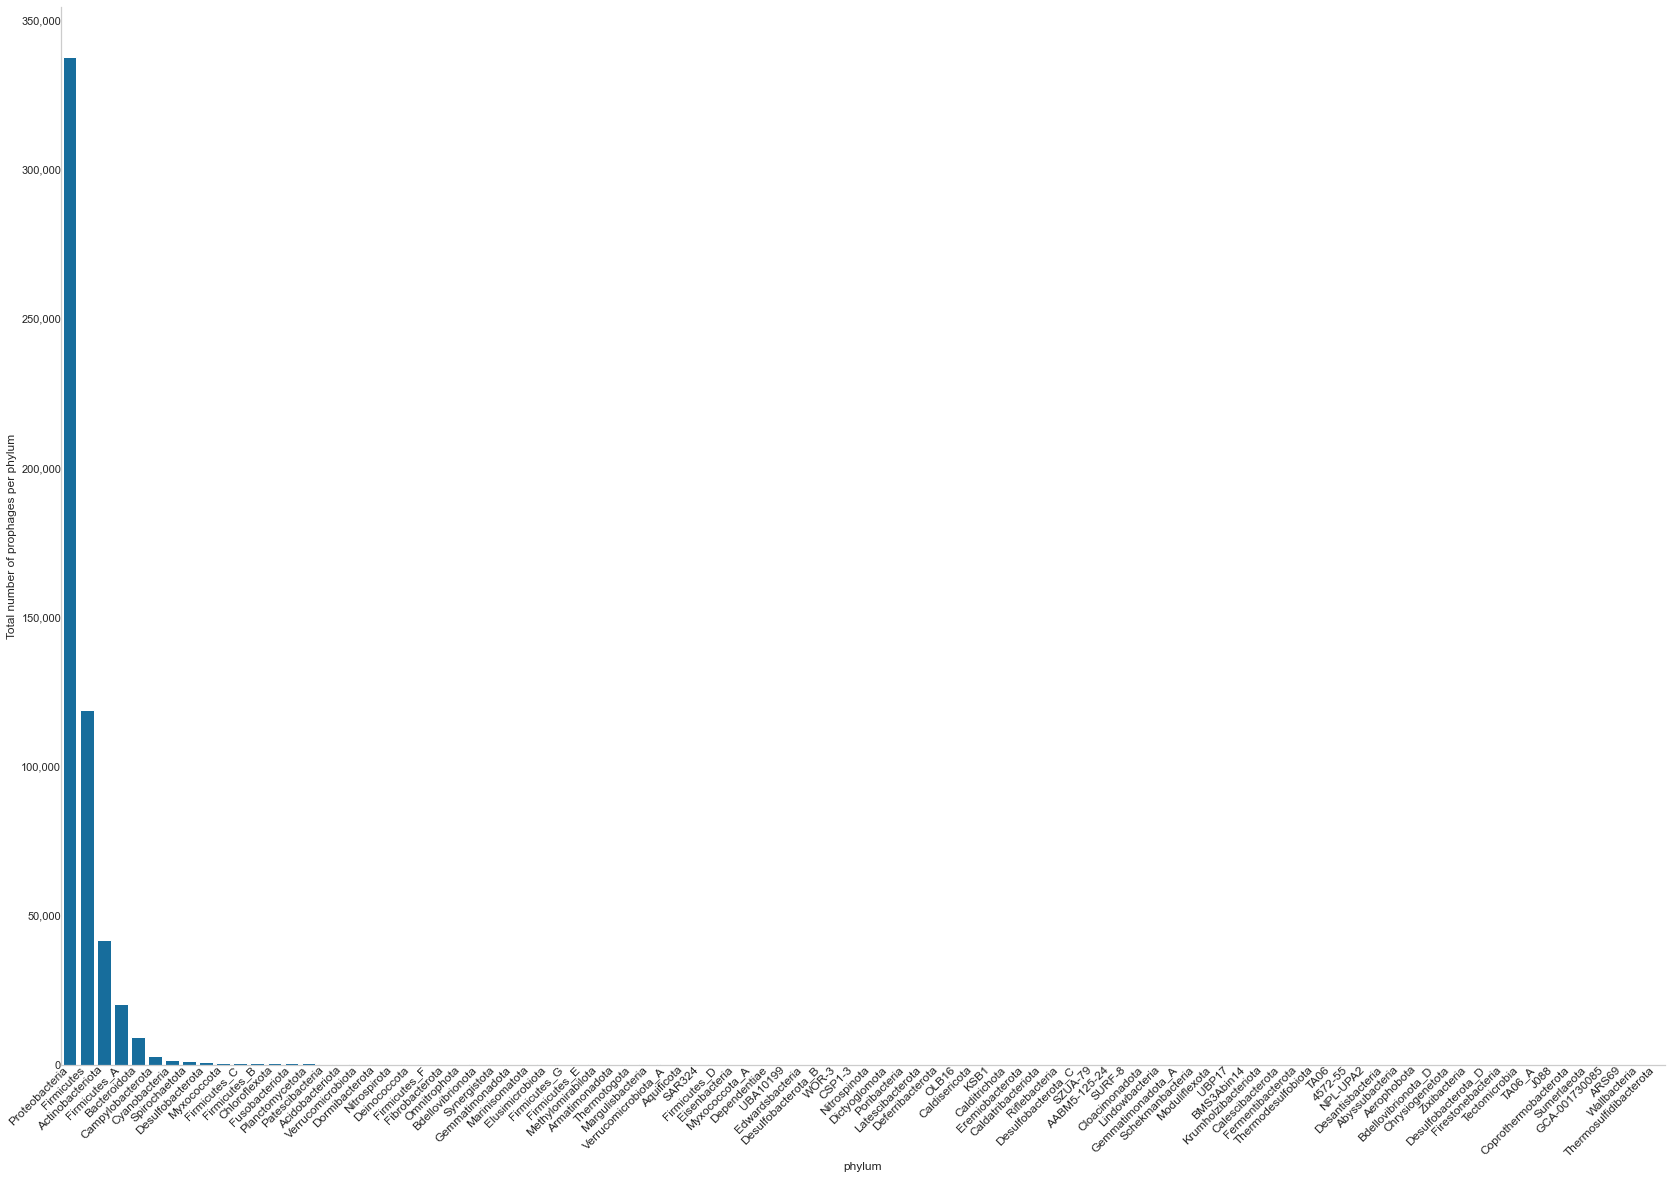

In [127]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x='phylum', y='Kept', data=phsum.sort_values(ascending=False, by='Kept'), ax=ax, label=c, color=sns.color_palette("colorblind")[0])

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
#ax.set_title(f"Total number of prophages per phyla")

# add a slight offset for every other tick label

"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

ax.grid(False)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Total number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phylaTotal.png')
fig.savefig('images/phylaTotal.svg')

<ipython-input-131-8a09a4bd52de>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)


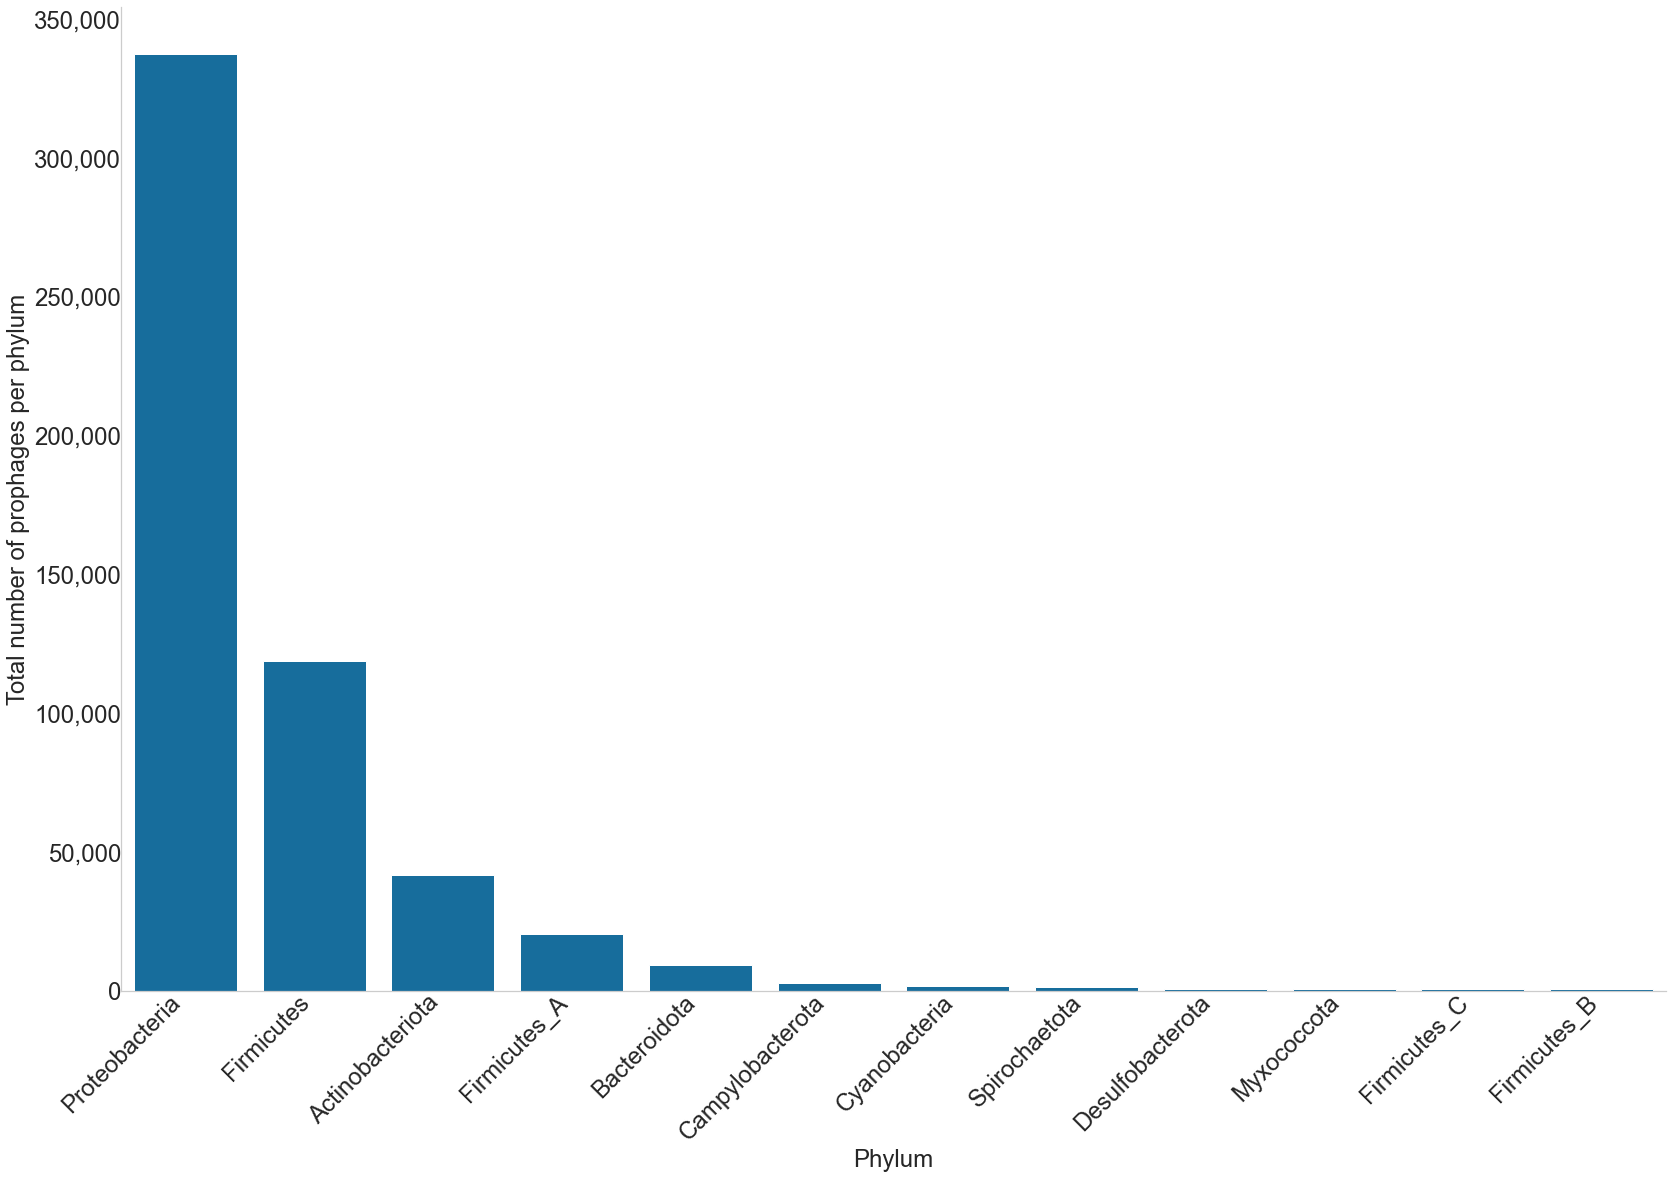

In [131]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x='phylum', y='Kept', data=phsum[phsum['Kept']>450].sort_values(ascending=False, by='Kept'), ax=ax, label=c, color=sns.color_palette("colorblind")[0])

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=24)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
#ax.set_title(f"Total number of prophages per phyla (phyla with >500 prophages)", fontsize=24)

# add a slight offset for every other tick label

"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

ax.grid(False)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Total number of prophages per phylum', fontsize=24)
ax.set_xlabel('Phylum', fontsize=24)
plt.tight_layout()
fig.savefig('images/phylaTotal_top500.png')
fig.savefig('images/phylaTotal_top500.svg')

In [76]:
tx = "**Fig. S\*\* Phages predicted per bacterial phyla.** Most of the predictions are from"
for idx, row in cvtax.groupby('phylum').sum().sort_values(by='Kept', ascending=False).head(5).iterrows():
    tx += f" {idx} ({int(row['Kept']):,} phages),"
printmd(tx)


<span style='color:black'>**Fig. S\*\* Phages predicted per bacterial phyla.** Most of the predictions are from Proteobacteria (337,491 phages), Firmicutes (118,819 phages), Actinobacteriota (41,806 phages), Firmicutes_A (20,296 phages), Bacteroidota (9,339 phages),</span>

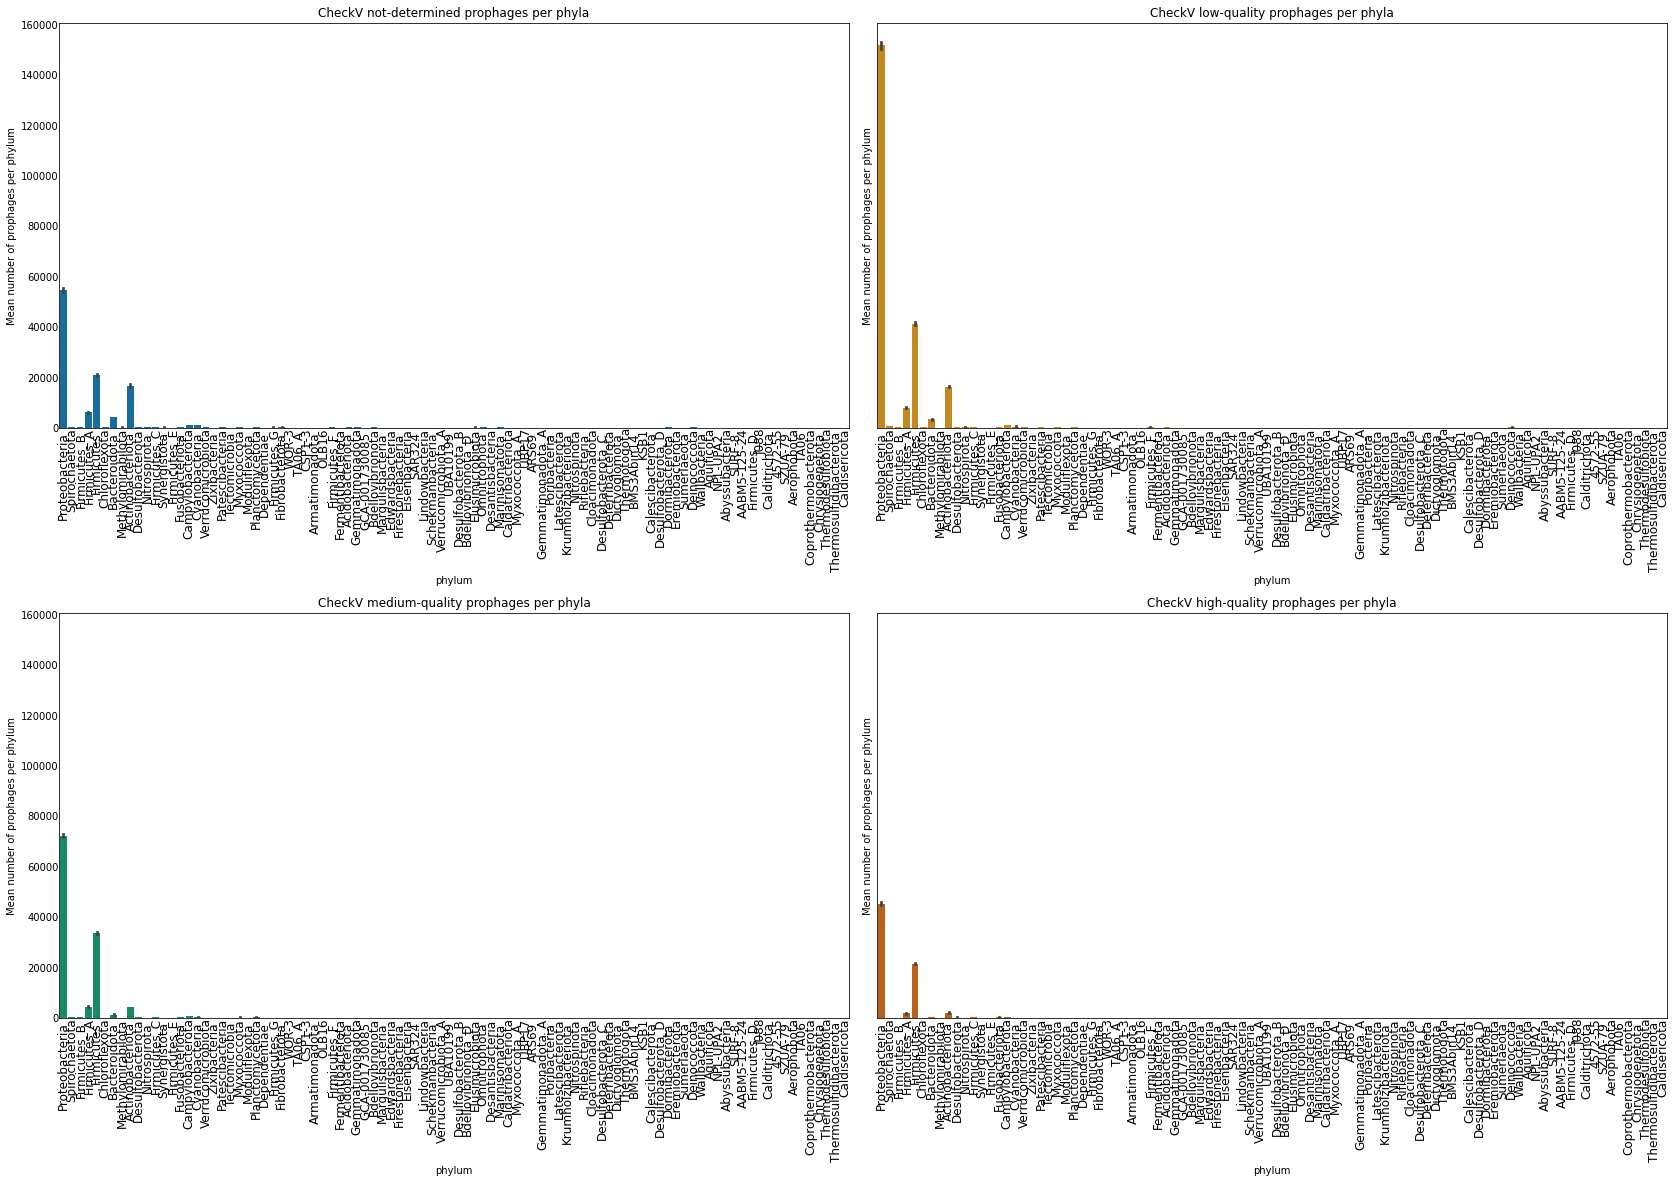

In [77]:
fig, axes = plt.subplots(2,2, figsize=(23.4,16.54), sharey=True)

col =  [['Not-determined', 'Low-quality'], ['Medium-quality', 'High-quality']]

for i in 0, 1:
    for j in 0, 1:
        c = col[i][j]
        ax = axes[i][j]
        sns.barplot(x='phylum', y=c, data=cvtax, ax=ax, label=c, color=sns.color_palette("colorblind")[(2*i) + j], estimator=sum)

        # get the tick labels and change some parameters about them.
        ticks_loc = ax.get_xticklabels()
        l = ax.set_xticklabels(ticks_loc, rotation=90, horizontalalignment='center', fontsize=12)
        # use this to hide every other tick
        # [x.set_visible(False) for x in l[::2]]

        ax.set_title(f"CheckV {c.lower()} prophages per phyla")
        # add a slight offset for every other tick label
        for alab in l[::2]:
            x, y = alab.get_position()
            alab.set_position((x, y-0.01))

        # turn off the ticks themselves
        ax.tick_params(length=0, pad=0)
        ax.set_ylabel('Mean number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phyla.png')
fig.savefig('images/phyla.svg')


<div style="background-color:lightyellow">

    
<h1>Statistical Analyses</h1>
    

Some stats on the number of prophages per taxonomic classification
    </div>

# Effect Size Calculations

Our datasets are so large that even small effect sizes may have statistically significant differences. There is lots of discussion about this, for example see these posts and articles:

* [Effect size, confidence interval and statistical significance: a practical guide for biologists](https://people.kth.se/~lang/Effect_size.pdf)
* [It's the Effect Size, Stupid! What effect size is and why it is important](http://www.leeds.ac.uk/educol/documents/00002182.htm)
* [Large scale statistical analysis discussion on stats stackexchange](https://stats.stackexchange.com/questions/7815/what-skills-are-required-to-perform-large-scale-statistical-analyses)
* [Large data sets and hypothesis testing](https://stats.stackexchange.com/questions/2516/are-large-data-sets-inappropriate-for-hypothesis-testing)
* [The Dangers of Large Data Sets: A Tale of P values, Error Rates, and Bonferroni Corrections](https://thelogicofscience.com/2015/04/07/basic-statistics-part-3-the-dangers-of-large-data-sets-a-tale-of-p-values-error-rates-and-bonferroni-corrections/)
* [The Unofficial Google Data Blog](http://www.unofficialgoogledatascience.com/2016/10/practical-advice-for-analysis-of-large.html)

Because of these concerns, we include two measures of effect size.

## Cohen's f<sup>2</sup>

This is a measure of the effect size from the ANOVA:

f<sup>2</sup> = &#x003B7;<sup>2</sup>/(1 - &#x003B7;<sup>2</sup>)

This measures the combined effect size, and does not provide a pairwise comparison of the data.

According to Cohen (1988; pg. 413; Chapter 9) the effect sizes are: 

 * small effect size: f<sup>2</sup> = 0.02
 * medium effect size: f<sup>2</sup> = 0.15
 * large effect size: f<sup>2</sup> = 0.35

See chapter 9 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

# Cohen's d

This is a pairwise measure of the effect size, and can be used to compare our different groups or samples thereof.

According to Cohen (1988; pg. 26; Chapter 2) the effect sizes are:

 * small effect size: d = 0.2
 * medium effect size: d = 0.5
 * large effect size: d = 0.8
 
For a detailed exposition, see chapter 2 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

In [78]:
def cohen_f(ssr,sse):
    """
    Calculate Cohen's f-squared from the Sum of Squares of Regression (SSR)
    and the Sum of Squares of Error (SSE).
    
    SSR is from the anova table as aov_table['sum_sq'][0]
    SSE is from the anova table as aov_table['sum_sq'][1]
    """
    
    rsq = ssr / (ssr + sse) # R^2 = SSR/SST
    return rsq / (1-rsq)

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    if np.isnan(d):
        # sys.stderr.write(f"{x} ~ {y} returned NaN\n")
        return 0
    return d

# Make sure the data is the same.

We are going to check the number of contigs, the number of basepairs

In [79]:
print("Phylum\tMinimum number of prophages\tMaximum number of prophages\tMean number of prophages\tMedian number of prophages\tStandard deviation")
for p in sorted(pd.unique(cvtax['phylum'])):
    d = cvtax[cvtax['phylum'] == p]
    count = d.Kept.count()
    m = d.Kept.min()
    x = d.Kept.max()
    n = round(d.Kept.mean(), 2)
    e = round(d.Kept.median(), 2)
    s = round(d.Kept.std(), 2)
    if np.isnan(s):
        s = ""
    print("\t".join(map(str, [p, m, x, n, e, s])))

Phylum	Minimum number of prophages	Maximum number of prophages	Mean number of prophages	Median number of prophages	Standard deviation
4572-55	2.0	2.0	2.0	2.0	
AABM5-125-24	2.0	2.0	2.0	2.0	0.0
ARS69	1.0	1.0	1.0	1.0	
Abyssubacteria	2.0	2.0	2.0	2.0	
Acidobacteriota	1.0	15.0	3.05	2.0	2.48
Actinobacteriota	1.0	74.0	3.54	3.0	3.24
Aerophobota	1.0	1.0	1.0	1.0	0.0
Aquificota	1.0	4.0	1.92	2.0	0.9
Armatimonadota	1.0	6.0	2.54	2.0	1.71
BMS3Abin14	3.0	3.0	3.0	3.0	
Bacteroidota	1.0	18.0	3.29	3.0	2.44
Bdellovibrionota	1.0	8.0	1.57	1.0	1.37
Bdellovibrionota_D	2.0	2.0	2.0	2.0	
CSP1-3	1.0	3.0	1.5	1.0	0.84
Caldatribacteriota	1.0	1.0	1.0	1.0	0.0
Caldisericota	1.0	2.0	1.17	1.0	0.41
Calditrichota	1.0	2.0	1.75	2.0	0.5
Calescibacterota	3.0	3.0	3.0	3.0	
Campylobacterota	1.0	7.0	1.82	2.0	0.92
Chloroflexota	1.0	34.0	2.82	2.0	3.91
Chrysiogenetota	2.0	2.0	2.0	2.0	
Cloacimonadota	1.0	1.0	1.0	1.0	0.0
Coprothermobacterota	1.0	1.0	1.0	1.0	
Cyanobacteria	1.0	19.0	3.62	3.0	2.79
Deferribacterota	1.0	4.0	2.33	2.0	1.53
Dein

# Anovas

I've used two different ways to calculate the ANOVA. The first is using _scipy.stats_ function _f\_oneway_ and the second is with statsmodels

### Calculate the one-way anova for all the data

Here, we group by _to_phylum_ and then compare the number of prophages in each group. Note that _group\_by_ returns a tuple of the grouped by name and the dataframe for that group, so _names_ is an array of the names and has the same dimension as _samples_. The 2D array _samples_ has one dimension for each name and the other for the number of prophages for that name.

In [80]:
samples = []
names = []
for nm, groupdf in cvtax.groupby('phylum'):
    names.append(nm)
    samples.append(groupdf['Kept'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 197.365, p value: 0.000


### Repeat for order

Is there a significant difference in order

In [81]:
samples = []
names = []
for nm, groupdf in cvtax.groupby('order'):
    names.append(nm)
    samples.append(groupdf['Kept'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 64.684, p value: 0.000


### Using statsmodels

Here we make a regression model on phylum.


In [82]:
mod = ols('Kept ~ phylum', data=cvtax).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {:,}) = {}, *p* = {}".format(
    int(aov_table.df['phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['phylum'], 2),
    round(aov_table.get("PR(>F)")['phylum'], 4)
))

                sum_sq        df           F  PR(>F)
phylum    1.906498e+05      93.0  197.365355     0.0
Residual  1.174251e+06  113052.0         NaN     NaN



<span style='color:black'>Report as: *F*(93, 113,052) = 197.37, *p* = 0.0</span>

In [83]:
mod = ols('Kept ~ order', data=cvtax).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {:,}) = {}, *p* = {}".format(
    int(aov_table.df['order']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['order'], 2),
    round(aov_table.get("PR(>F)")['order'], 4)
))

                sum_sq        df          F  PR(>F)
order     3.313430e+05     558.0  64.684047     0.0
Residual  1.033557e+06  112587.0        NaN     NaN



<span style='color:black'>Report as: *F*(558, 112,587) = 64.68, *p* = 0.0</span>

### Use Tukey's honestly significant difference test to compare the data

This performs pairwise comparisons on our data. The NULL hypothesis is that there is no statistical difference in the means of the two samples. If we reject that NULL hypothesis (reject == True) then we have reason to believe that there is a significan difference in the means of the samples.

In [84]:
rec = pairwise_tukeyhsd(cvtax['Kept'], cvtax['phylum'])
print(rec)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------------
               4572-55           AABM5-125-24      0.0    0.9 -16.8785 16.8785  False
               4572-55                  ARS69     -1.0    0.9 -20.4896 18.4896  False
               4572-55         Abyssubacteria      0.0    0.9 -19.4896 19.4896  False
               4572-55        Acidobacteriota    1.049    0.9 -12.7996 14.8977  False
               4572-55       Actinobacteriota   1.5432    0.9 -12.2387  15.325  False
               4572-55            Aerophobota     -1.0    0.9 -17.8785 15.8785  False
               4572-55             Aquificota  -0.0833    0.9 -14.4273 14.2607  False
               4572-55         Armatimonadota   0.5385    0.9  -13.763   14.84  False
               4572-55             BMS3Abin14      1.0

In [85]:
tukeysres = pd.DataFrame(data=rec._results_table.data[1:], columns=rec._results_table.data[0])
tukeysres[tukeysres['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
403,Acidobacteriota,Firmicutes_A,2.2724,0.0010,0.8898,3.6551,True
423,Acidobacteriota,Myxococcota,2.4510,0.0010,0.5803,4.3216,True
430,Acidobacteriota,Patescibacteria,-1.9090,0.0010,-3.4840,-0.3340,True
433,Acidobacteriota,Proteobacteria,2.9417,0.0010,1.5759,4.3074,True
467,Actinobacteriota,Campylobacterota,-1.7235,0.0010,-2.1017,-1.3454,True
...,...,...,...,...,...,...,...
4147,Proteobacteria,Synergistota,-4.1976,0.0010,-6.7574,-1.6378,True
4153,Proteobacteria,Thermotogota,-4.8478,0.0010,-7.4529,-2.2428,True
4154,Proteobacteria,UBA10199,-4.8240,0.0010,-8.8027,-0.8453,True
4156,Proteobacteria,Verrucomicrobiota,-4.2375,0.0010,-5.3354,-3.1396,True


## Effect size

We measure the effect size of the group as a whole from the anova using Cohen's f<sup>2</sup> and pairwise using Cohen's d.

In [86]:
phyla = pd.unique(cvtax['phylum'])
for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            continue
        print("Cohen's d for {} - {}: {}".format(c, d, round(
            cohen_d(
                cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'], 
        ), 2)))

Cohen's d for Proteobacteria - Spirochaetota: 0.92
Cohen's d for Proteobacteria - Firmicutes_B: 0.61
Cohen's d for Proteobacteria - Firmicutes_A: 0.17
Cohen's d for Proteobacteria - Firmicutes: 0.74
Cohen's d for Proteobacteria - Chloroflexota: 0.82
Cohen's d for Proteobacteria - Bacteroidota: 0.71
Cohen's d for Proteobacteria - Methylomirabilota: 1.17
Cohen's d for Proteobacteria - Actinobacteriota: 0.65
Cohen's d for Proteobacteria - Desulfobacterota: 0.8
Cohen's d for Proteobacteria - Nitrospirota: 0.92
Cohen's d for Proteobacteria - Firmicutes_C: 0.7
Cohen's d for Proteobacteria - Synergistota: 1.08
Cohen's d for Proteobacteria - Firmicutes_E: 0.94
Cohen's d for Proteobacteria - Fusobacteriota: 0.75
Cohen's d for Proteobacteria - Campylobacterota: 1.09
Cohen's d for Proteobacteria - Cyanobacteria: 0.61
Cohen's d for Proteobacteria - Verrucomicrobiota: 1.09
Cohen's d for Proteobacteria - Zixibacteria: 1.29
Cohen's d for Proteobacteria - Patescibacteria: 1.25
Cohen's d for Proteobact

Cohen's d for Spirochaetota - Sumerlaeota: 0
Cohen's d for Spirochaetota - Deinococcota: 0.07
Cohen's d for Spirochaetota - Wallbacteria: 0
Cohen's d for Spirochaetota - Aquificota: 0.34
Cohen's d for Spirochaetota - NPL-UPA2: 0
Cohen's d for Spirochaetota - Abyssubacteria: 0
Cohen's d for Spirochaetota - SURF-8: 0
Cohen's d for Spirochaetota - AABM5-125-24: 0.29
Cohen's d for Spirochaetota - Firmicutes_D: -0.25
Cohen's d for Spirochaetota - J088: 0
Cohen's d for Spirochaetota - Calditrichota: 0.45
Cohen's d for Spirochaetota - 4572-55: 0
Cohen's d for Spirochaetota - SZUA-79: 0.29
Cohen's d for Spirochaetota - Aerophobota: 0.94
Cohen's d for Spirochaetota - TA06: 0
Cohen's d for Spirochaetota - Coprothermobacterota: 0
Cohen's d for Spirochaetota - Chrysiogenetota: 0
Cohen's d for Spirochaetota - Thermodesulfobiota: 0
Cohen's d for Spirochaetota - Thermosulfidibacterota: 0
Cohen's d for Spirochaetota - Caldisericota: 0.83
Cohen's d for Firmicutes_B - Firmicutes_A: -0.53
Cohen's d for F

Cohen's d for Firmicutes_A - Calescibacterota: 0
Cohen's d for Firmicutes_A - Desulfobacterota_D: 1.36
Cohen's d for Firmicutes_A - Dormibacterota: 0.4
Cohen's d for Firmicutes_A - Eremiobacterota: 1.2
Cohen's d for Firmicutes_A - Sumerlaeota: 0
Cohen's d for Firmicutes_A - Deinococcota: 0.94
Cohen's d for Firmicutes_A - Wallbacteria: 0
Cohen's d for Firmicutes_A - Aquificota: 1.07
Cohen's d for Firmicutes_A - NPL-UPA2: 0
Cohen's d for Firmicutes_A - Abyssubacteria: 0
Cohen's d for Firmicutes_A - SURF-8: 0
Cohen's d for Firmicutes_A - AABM5-125-24: 1.04
Cohen's d for Firmicutes_A - Firmicutes_D: 0.78
Cohen's d for Firmicutes_A - J088: 0
Cohen's d for Firmicutes_A - Calditrichota: 1.12
Cohen's d for Firmicutes_A - 4572-55: 0
Cohen's d for Firmicutes_A - SZUA-79: 1.04
Cohen's d for Firmicutes_A - Aerophobota: 1.36
Cohen's d for Firmicutes_A - TA06: 0
Cohen's d for Firmicutes_A - Coprothermobacterota: 0
Cohen's d for Firmicutes_A - Chrysiogenetota: 0
Cohen's d for Firmicutes_A - Thermodes

Cohen's d for Chloroflexota - KSB1: 0.28
Cohen's d for Chloroflexota - Calescibacterota: 0
Cohen's d for Chloroflexota - Desulfobacterota_D: 0.47
Cohen's d for Chloroflexota - Dormibacterota: -0.28
Cohen's d for Chloroflexota - Eremiobacterota: 0.34
Cohen's d for Chloroflexota - Sumerlaeota: 0
Cohen's d for Chloroflexota - Deinococcota: 0.14
Cohen's d for Chloroflexota - Wallbacteria: 0
Cohen's d for Chloroflexota - Aquificota: 0.24
Cohen's d for Chloroflexota - NPL-UPA2: 0
Cohen's d for Chloroflexota - Abyssubacteria: 0
Cohen's d for Chloroflexota - SURF-8: 0
Cohen's d for Chloroflexota - AABM5-125-24: 0.21
Cohen's d for Chloroflexota - Firmicutes_D: -0.0
Cohen's d for Chloroflexota - J088: 0
Cohen's d for Chloroflexota - Calditrichota: 0.28
Cohen's d for Chloroflexota - 4572-55: 0
Cohen's d for Chloroflexota - SZUA-79: 0.21
Cohen's d for Chloroflexota - Aerophobota: 0.47
Cohen's d for Chloroflexota - TA06: 0
Cohen's d for Chloroflexota - Coprothermobacterota: 0
Cohen's d for Chlorofl

Cohen's d for Methylomirabilota - Krumholzibacteriota: 0.58
Cohen's d for Methylomirabilota - Nitrospinota: 0.2
Cohen's d for Methylomirabilota - Riflebacteria: -0.28
Cohen's d for Methylomirabilota - Cloacimonadota: 0.59
Cohen's d for Methylomirabilota - Desulfobacterota_C: -0.28
Cohen's d for Methylomirabilota - Deferribacterota: -1.03
Cohen's d for Methylomirabilota - Dictyoglomota: -1.01
Cohen's d for Methylomirabilota - Thermotogota: 0.49
Cohen's d for Methylomirabilota - BMS3Abin14: 0
Cohen's d for Methylomirabilota - KSB1: -0.39
Cohen's d for Methylomirabilota - Calescibacterota: 0
Cohen's d for Methylomirabilota - Desulfobacterota_D: 0.56
Cohen's d for Methylomirabilota - Dormibacterota: -0.55
Cohen's d for Methylomirabilota - Eremiobacterota: -0.08
Cohen's d for Methylomirabilota - Sumerlaeota: 0
Cohen's d for Methylomirabilota - Deinococcota: -0.61
Cohen's d for Methylomirabilota - Wallbacteria: 0
Cohen's d for Methylomirabilota - Aquificota: -0.58
Cohen's d for Methylomirabi

Cohen's d for Desulfobacterota - Gemmatimonadota_A: 0
Cohen's d for Desulfobacterota - Poribacteria: 0.7
Cohen's d for Desulfobacterota - Latescibacterota: 0.79
Cohen's d for Desulfobacterota - Krumholzibacteriota: 0.95
Cohen's d for Desulfobacterota - Nitrospinota: 0.81
Cohen's d for Desulfobacterota - Riflebacteria: 0.61
Cohen's d for Desulfobacterota - Cloacimonadota: 0.96
Cohen's d for Desulfobacterota - Desulfobacterota_C: 0.61
Cohen's d for Desulfobacterota - Deferribacterota: 0.28
Cohen's d for Desulfobacterota - Dictyoglomota: 0.32
Cohen's d for Desulfobacterota - Thermotogota: 0.92
Cohen's d for Desulfobacterota - BMS3Abin14: 0
Cohen's d for Desulfobacterota - KSB1: 0.57
Cohen's d for Desulfobacterota - Calescibacterota: 0
Cohen's d for Desulfobacterota - Desulfobacterota_D: 0.95
Cohen's d for Desulfobacterota - Dormibacterota: -0.4
Cohen's d for Desulfobacterota - Eremiobacterota: 0.7
Cohen's d for Desulfobacterota - Sumerlaeota: 0
Cohen's d for Desulfobacterota - Deinococcot

Cohen's d for Firmicutes_C - Dictyoglomota: 0.43
Cohen's d for Firmicutes_C - Thermotogota: 0.94
Cohen's d for Firmicutes_C - BMS3Abin14: 0
Cohen's d for Firmicutes_C - KSB1: 0.64
Cohen's d for Firmicutes_C - Calescibacterota: 0
Cohen's d for Firmicutes_C - Desulfobacterota_D: 0.94
Cohen's d for Firmicutes_C - Dormibacterota: -0.22
Cohen's d for Firmicutes_C - Eremiobacterota: 0.74
Cohen's d for Firmicutes_C - Sumerlaeota: 0
Cohen's d for Firmicutes_C - Deinococcota: 0.42
Cohen's d for Firmicutes_C - Wallbacteria: 0
Cohen's d for Firmicutes_C - Aquificota: 0.58
Cohen's d for Firmicutes_C - NPL-UPA2: 0
Cohen's d for Firmicutes_C - Abyssubacteria: 0
Cohen's d for Firmicutes_C - SURF-8: 0
Cohen's d for Firmicutes_C - AABM5-125-24: 0.53
Cohen's d for Firmicutes_C - Firmicutes_D: 0.19
Cohen's d for Firmicutes_C - J088: 0
Cohen's d for Firmicutes_C - Calditrichota: 0.64
Cohen's d for Firmicutes_C - 4572-55: 0
Cohen's d for Firmicutes_C - SZUA-79: 0.53
Cohen's d for Firmicutes_C - Aerophobota

Cohen's d for Firmicutes_E - J088: 0
Cohen's d for Firmicutes_E - Calditrichota: 0.33
Cohen's d for Firmicutes_E - 4572-55: 0
Cohen's d for Firmicutes_E - SZUA-79: 0.18
Cohen's d for Firmicutes_E - Aerophobota: 0.72
Cohen's d for Firmicutes_E - TA06: 0
Cohen's d for Firmicutes_E - Coprothermobacterota: 0
Cohen's d for Firmicutes_E - Chrysiogenetota: 0
Cohen's d for Firmicutes_E - Thermodesulfobiota: 0
Cohen's d for Firmicutes_E - Thermosulfidibacterota: 0
Cohen's d for Firmicutes_E - Caldisericota: 0.7
Cohen's d for Fusobacteriota - Campylobacterota: 1.26
Cohen's d for Fusobacteriota - Cyanobacteria: -0.21
Cohen's d for Fusobacteriota - Verrucomicrobiota: 0.94
Cohen's d for Fusobacteriota - Zixibacteria: 1.21
Cohen's d for Fusobacteriota - Patescibacteria: 1.88
Cohen's d for Fusobacteriota - Tectomicrobia: 0
Cohen's d for Fusobacteriota - Myxococcota: -0.71
Cohen's d for Fusobacteriota - Moduliflexota: 0.92
Cohen's d for Fusobacteriota - Planctomycetota: 0.07
Cohen's d for Fusobacterio

Cohen's d for Cyanobacteria - Zixibacteria: 0.94
Cohen's d for Cyanobacteria - Patescibacteria: 1.15
Cohen's d for Cyanobacteria - Tectomicrobia: 0
Cohen's d for Cyanobacteria - Myxococcota: -0.57
Cohen's d for Cyanobacteria - Moduliflexota: 0.76
Cohen's d for Cyanobacteria - Planctomycetota: 0.25
Cohen's d for Cyanobacteria - Dependentiae: 0.48
Cohen's d for Cyanobacteria - Firmicutes_G: 0.57
Cohen's d for Cyanobacteria - Fibrobacterota: 0.64
Cohen's d for Cyanobacteria - WOR-3: 0.81
Cohen's d for Cyanobacteria - TA06_A: 0
Cohen's d for Cyanobacteria - CSP1-3: 0.77
Cohen's d for Cyanobacteria - Armatimonadota: 0.39
Cohen's d for Cyanobacteria - OLB16: 0.04
Cohen's d for Cyanobacteria - Firmicutes_F: 0.11
Cohen's d for Cyanobacteria - Fermentibacterota: 0.94
Cohen's d for Cyanobacteria - Acidobacteriota: 0.21
Cohen's d for Cyanobacteria - Gemmatimonadota: 0.85
Cohen's d for Cyanobacteria - GCA-001730085: 0
Cohen's d for Cyanobacteria - Bdellovibrionota: 0.76
Cohen's d for Cyanobacteria

Cohen's d for Zixibacteria - TA06_A: 0
Cohen's d for Zixibacteria - CSP1-3: -0.65
Cohen's d for Zixibacteria - Armatimonadota: -0.93
Cohen's d for Zixibacteria - OLB16: -1.0
Cohen's d for Zixibacteria - Firmicutes_F: -1.65
Cohen's d for Zixibacteria - Fermentibacterota: 0
Cohen's d for Zixibacteria - Acidobacteriota: -0.83
Cohen's d for Zixibacteria - Gemmatimonadota: -0.55
Cohen's d for Zixibacteria - GCA-001730085: 0
Cohen's d for Zixibacteria - Bdellovibrionota: -0.42
Cohen's d for Zixibacteria - Margulisbacteria: -0.44


<ipython-input-78-643cf20872f7>:17: RuntimeWarning: invalid value encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


Cohen's d for Zixibacteria - Edwardsbacteria: -1.73
Cohen's d for Zixibacteria - Firestonebacteria: 0
Cohen's d for Zixibacteria - Eisenbacteria: -1.0
Cohen's d for Zixibacteria - SAR324: -0.55
Cohen's d for Zixibacteria - Lindowbacteria: -inf
Cohen's d for Zixibacteria - Schekmanbacteria: -1.0
Cohen's d for Zixibacteria - Verrucomicrobiota_A: -0.74
Cohen's d for Zixibacteria - UBA10199: -0.3
Cohen's d for Zixibacteria - Desulfobacterota_B: -0.85
Cohen's d for Zixibacteria - Bdellovibrionota_D: 0
Cohen's d for Zixibacteria - Elusimicrobiota: -0.58


<ipython-input-78-643cf20872f7>:17: RuntimeWarning: divide by zero encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


Cohen's d for Zixibacteria - Omnitrophota: -0.61
Cohen's d for Zixibacteria - Desantisbacteria: 0
Cohen's d for Zixibacteria - Marinisomatota: -0.36
Cohen's d for Zixibacteria - Caldatribacteriota: 0
Cohen's d for Zixibacteria - Myxococcota_A: -1.01
Cohen's d for Zixibacteria - UBP17: 0
Cohen's d for Zixibacteria - ARS69: 0
Cohen's d for Zixibacteria - Gemmatimonadota_A: 0
Cohen's d for Zixibacteria - Poribacteria: -1.0
Cohen's d for Zixibacteria - Latescibacterota: -0.71
Cohen's d for Zixibacteria - Krumholzibacteriota: 0
Cohen's d for Zixibacteria - Nitrospinota: -0.63
Cohen's d for Zixibacteria - Riflebacteria: -0.71
Cohen's d for Zixibacteria - Cloacimonadota: 0
Cohen's d for Zixibacteria - Desulfobacterota_C: -0.71
Cohen's d for Zixibacteria - Deferribacterota: -1.07
Cohen's d for Zixibacteria - Dictyoglomota: -1.51
Cohen's d for Zixibacteria - Thermotogota: -0.41
Cohen's d for Zixibacteria - BMS3Abin14: 0
Cohen's d for Zixibacteria - KSB1: -0.9
Cohen's d for Zixibacteria - Calesc

Cohen's d for Tectomicrobia - Desulfobacterota_D: 0
Cohen's d for Tectomicrobia - Dormibacterota: 0
Cohen's d for Tectomicrobia - Eremiobacterota: 0
Cohen's d for Tectomicrobia - Sumerlaeota: 0
Cohen's d for Tectomicrobia - Deinococcota: 0
Cohen's d for Tectomicrobia - Wallbacteria: 0
Cohen's d for Tectomicrobia - Aquificota: 0
Cohen's d for Tectomicrobia - NPL-UPA2: 0
Cohen's d for Tectomicrobia - Abyssubacteria: 0
Cohen's d for Tectomicrobia - SURF-8: 0
Cohen's d for Tectomicrobia - AABM5-125-24: 0
Cohen's d for Tectomicrobia - Firmicutes_D: 0
Cohen's d for Tectomicrobia - J088: 0
Cohen's d for Tectomicrobia - Calditrichota: 0
Cohen's d for Tectomicrobia - 4572-55: 0
Cohen's d for Tectomicrobia - SZUA-79: 0
Cohen's d for Tectomicrobia - Aerophobota: 0
Cohen's d for Tectomicrobia - TA06: 0
Cohen's d for Tectomicrobia - Coprothermobacterota: 0
Cohen's d for Tectomicrobia - Chrysiogenetota: 0
Cohen's d for Tectomicrobia - Thermodesulfobiota: 0
Cohen's d for Tectomicrobia - Thermosulfidi

Cohen's d for Planctomycetota - Firmicutes_F: -0.16
Cohen's d for Planctomycetota - Fermentibacterota: 0.83
Cohen's d for Planctomycetota - Acidobacteriota: -0.04
Cohen's d for Planctomycetota - Gemmatimonadota: 0.75
Cohen's d for Planctomycetota - GCA-001730085: 0
Cohen's d for Planctomycetota - Bdellovibrionota: 0.63
Cohen's d for Planctomycetota - Margulisbacteria: 0.66
Cohen's d for Planctomycetota - Edwardsbacteria: 0.41
Cohen's d for Planctomycetota - Firestonebacteria: 0.82
Cohen's d for Planctomycetota - Eisenbacteria: 0.41
Cohen's d for Planctomycetota - SAR324: 0.57
Cohen's d for Planctomycetota - Lindowbacteria: 0.4
Cohen's d for Planctomycetota - Schekmanbacteria: 0.61
Cohen's d for Planctomycetota - Verrucomicrobiota_A: 0.41
Cohen's d for Planctomycetota - UBA10199: 0.78
Cohen's d for Planctomycetota - Desulfobacterota_B: -0.02
Cohen's d for Planctomycetota - Bdellovibrionota_D: 0
Cohen's d for Planctomycetota - Elusimicrobiota: 0.75
Cohen's d for Planctomycetota - Omnitro

Cohen's d for Firmicutes_G - Riflebacteria: 0.4
Cohen's d for Firmicutes_G - Cloacimonadota: 1.22
Cohen's d for Firmicutes_G - Desulfobacterota_C: 0.4
Cohen's d for Firmicutes_G - Deferribacterota: -0.27
Cohen's d for Firmicutes_G - Dictyoglomota: -0.21
Cohen's d for Firmicutes_G - Thermotogota: 1.41
Cohen's d for Firmicutes_G - BMS3Abin14: 0
Cohen's d for Firmicutes_G - KSB1: 0.32
Cohen's d for Firmicutes_G - Calescibacterota: 0
Cohen's d for Firmicutes_G - Desulfobacterota_D: 1.16
Cohen's d for Firmicutes_G - Dormibacterota: -0.4
Cohen's d for Firmicutes_G - Eremiobacterota: 0.59
Cohen's d for Firmicutes_G - Sumerlaeota: 0
Cohen's d for Firmicutes_G - Deinococcota: -0.18
Cohen's d for Firmicutes_G - Wallbacteria: 0
Cohen's d for Firmicutes_G - Aquificota: 0.15
Cohen's d for Firmicutes_G - NPL-UPA2: 0
Cohen's d for Firmicutes_G - Abyssubacteria: 0
Cohen's d for Firmicutes_G - SURF-8: 0
Cohen's d for Firmicutes_G - AABM5-125-24: 0.06
Cohen's d for Firmicutes_G - Firmicutes_D: -0.65
Coh

Cohen's d for TA06_A - Caldatribacteriota: 0
Cohen's d for TA06_A - Myxococcota_A: 0
Cohen's d for TA06_A - UBP17: 0
Cohen's d for TA06_A - ARS69: 0
Cohen's d for TA06_A - Gemmatimonadota_A: 0
Cohen's d for TA06_A - Poribacteria: 0
Cohen's d for TA06_A - Latescibacterota: 0
Cohen's d for TA06_A - Krumholzibacteriota: 0
Cohen's d for TA06_A - Nitrospinota: 0
Cohen's d for TA06_A - Riflebacteria: 0
Cohen's d for TA06_A - Cloacimonadota: 0
Cohen's d for TA06_A - Desulfobacterota_C: 0
Cohen's d for TA06_A - Deferribacterota: 0
Cohen's d for TA06_A - Dictyoglomota: 0
Cohen's d for TA06_A - Thermotogota: 0
Cohen's d for TA06_A - BMS3Abin14: 0
Cohen's d for TA06_A - KSB1: 0
Cohen's d for TA06_A - Calescibacterota: 0
Cohen's d for TA06_A - Desulfobacterota_D: 0
Cohen's d for TA06_A - Dormibacterota: 0
Cohen's d for TA06_A - Eremiobacterota: 0
Cohen's d for TA06_A - Sumerlaeota: 0
Cohen's d for TA06_A - Deinococcota: 0
Cohen's d for TA06_A - Wallbacteria: 0
Cohen's d for TA06_A - Aquificota: 0


Cohen's d for OLB16 - Marinisomatota: 3.31
Cohen's d for OLB16 - Caldatribacteriota: 1.58
Cohen's d for OLB16 - Myxococcota_A: 0.66
Cohen's d for OLB16 - UBP17: 0
Cohen's d for OLB16 - ARS69: 0
Cohen's d for OLB16 - Gemmatimonadota_A: 0
Cohen's d for OLB16 - Poribacteria: 1.31
Cohen's d for OLB16 - Latescibacterota: 1.43
Cohen's d for OLB16 - Krumholzibacteriota: 1.22
Cohen's d for OLB16 - Nitrospinota: 1.57
Cohen's d for OLB16 - Riflebacteria: 0.82
Cohen's d for OLB16 - Cloacimonadota: 1.41
Cohen's d for OLB16 - Desulfobacterota_C: 0.82
Cohen's d for OLB16 - Deferribacterota: 0.49
Cohen's d for OLB16 - Dictyoglomota: 0.64
Cohen's d for OLB16 - Thermotogota: 3.13
Cohen's d for OLB16 - BMS3Abin14: 0
Cohen's d for OLB16 - KSB1: 0.9
Cohen's d for OLB16 - Calescibacterota: 0
Cohen's d for OLB16 - Desulfobacterota_D: 1.0
Cohen's d for OLB16 - Dormibacterota: -0.09
Cohen's d for OLB16 - Eremiobacterota: 1.02
Cohen's d for OLB16 - Sumerlaeota: 0
Cohen's d for OLB16 - Deinococcota: 0.69
Cohen'

Cohen's d for Acidobacteriota - Elusimicrobiota: 0.79
Cohen's d for Acidobacteriota - Omnitrophota: 0.8
Cohen's d for Acidobacteriota - Desantisbacteria: 0.83
Cohen's d for Acidobacteriota - Marinisomatota: 0.89
Cohen's d for Acidobacteriota - Caldatribacteriota: 0.84
Cohen's d for Acidobacteriota - Myxococcota_A: 0.31
Cohen's d for Acidobacteriota - UBP17: 0
Cohen's d for Acidobacteriota - ARS69: 0
Cohen's d for Acidobacteriota - Gemmatimonadota_A: 0
Cohen's d for Acidobacteriota - Poribacteria: 0.64
Cohen's d for Acidobacteriota - Latescibacterota: 0.71
Cohen's d for Acidobacteriota - Krumholzibacteriota: 0.84
Cohen's d for Acidobacteriota - Nitrospinota: 0.73
Cohen's d for Acidobacteriota - Riflebacteria: 0.56
Cohen's d for Acidobacteriota - Cloacimonadota: 0.84
Cohen's d for Acidobacteriota - Desulfobacterota_C: 0.56
Cohen's d for Acidobacteriota - Deferribacterota: 0.29
Cohen's d for Acidobacteriota - Dictyoglomota: 0.33
Cohen's d for Acidobacteriota - Thermotogota: 0.86
Cohen's d

Cohen's d for Bdellovibrionota - Lindowbacteria: -0.32
Cohen's d for Bdellovibrionota - Schekmanbacteria: 0.05
Cohen's d for Bdellovibrionota - Verrucomicrobiota_A: -0.31
Cohen's d for Bdellovibrionota - UBA10199: 0.32
Cohen's d for Bdellovibrionota - Desulfobacterota_B: -0.96
Cohen's d for Bdellovibrionota - Bdellovibrionota_D: 0
Cohen's d for Bdellovibrionota - Elusimicrobiota: 0.23
Cohen's d for Bdellovibrionota - Omnitrophota: 0.16
Cohen's d for Bdellovibrionota - Desantisbacteria: 0.42
Cohen's d for Bdellovibrionota - Marinisomatota: 0.4
Cohen's d for Bdellovibrionota - Caldatribacteriota: 0.43
Cohen's d for Bdellovibrionota - Myxococcota_A: -0.52
Cohen's d for Bdellovibrionota - UBP17: 0
Cohen's d for Bdellovibrionota - ARS69: 0
Cohen's d for Bdellovibrionota - Gemmatimonadota_A: 0
Cohen's d for Bdellovibrionota - Poribacteria: 0.05
Cohen's d for Bdellovibrionota - Latescibacterota: 0.18
Cohen's d for Bdellovibrionota - Krumholzibacteriota: 0.42
Cohen's d for Bdellovibrionota - N

Cohen's d for Firestonebacteria - Elusimicrobiota: -0.58
Cohen's d for Firestonebacteria - Omnitrophota: -0.61
Cohen's d for Firestonebacteria - Desantisbacteria: 0
Cohen's d for Firestonebacteria - Marinisomatota: -0.36
Cohen's d for Firestonebacteria - Caldatribacteriota: 0
Cohen's d for Firestonebacteria - Myxococcota_A: -1.01
Cohen's d for Firestonebacteria - UBP17: 0
Cohen's d for Firestonebacteria - ARS69: 0
Cohen's d for Firestonebacteria - Gemmatimonadota_A: 0
Cohen's d for Firestonebacteria - Poribacteria: -1.0
Cohen's d for Firestonebacteria - Latescibacterota: -0.71
Cohen's d for Firestonebacteria - Krumholzibacteriota: 0
Cohen's d for Firestonebacteria - Nitrospinota: -0.63
Cohen's d for Firestonebacteria - Riflebacteria: -0.71
Cohen's d for Firestonebacteria - Cloacimonadota: 0
Cohen's d for Firestonebacteria - Desulfobacterota_C: -0.71
Cohen's d for Firestonebacteria - Deferribacterota: -1.07
Cohen's d for Firestonebacteria - Dictyoglomota: -1.51
Cohen's d for Firestoneba

Cohen's d for Lindowbacteria - Sumerlaeota: 0
Cohen's d for Lindowbacteria - Deinococcota: -0.2
Cohen's d for Lindowbacteria - Wallbacteria: 0
Cohen's d for Lindowbacteria - Aquificota: 0.1
Cohen's d for Lindowbacteria - NPL-UPA2: 0
Cohen's d for Lindowbacteria - Abyssubacteria: 0
Cohen's d for Lindowbacteria - SURF-8: 0
Cohen's d for Lindowbacteria - AABM5-125-24: 0
Cohen's d for Lindowbacteria - Firmicutes_D: -0.5
Cohen's d for Lindowbacteria - J088: 0
Cohen's d for Lindowbacteria - Calditrichota: 0.58
Cohen's d for Lindowbacteria - 4572-55: 0
Cohen's d for Lindowbacteria - SZUA-79: 0
Cohen's d for Lindowbacteria - Aerophobota: inf
Cohen's d for Lindowbacteria - TA06: 0
Cohen's d for Lindowbacteria - Coprothermobacterota: 0
Cohen's d for Lindowbacteria - Chrysiogenetota: 0
Cohen's d for Lindowbacteria - Thermodesulfobiota: 0
Cohen's d for Lindowbacteria - Thermosulfidibacterota: 0
Cohen's d for Lindowbacteria - Caldisericota: 2.24
Cohen's d for Schekmanbacteria - Verrucomicrobiota_A:

Cohen's d for Desulfobacterota_B - Desantisbacteria: 0.85
Cohen's d for Desulfobacterota_B - Marinisomatota: 2.19
Cohen's d for Desulfobacterota_B - Caldatribacteriota: 1.13
Cohen's d for Desulfobacterota_B - Myxococcota_A: 0.37
Cohen's d for Desulfobacterota_B - UBP17: 0
Cohen's d for Desulfobacterota_B - ARS69: 0
Cohen's d for Desulfobacterota_B - Gemmatimonadota_A: 0
Cohen's d for Desulfobacterota_B - Poribacteria: 0.88
Cohen's d for Desulfobacterota_B - Latescibacterota: 0.98
Cohen's d for Desulfobacterota_B - Krumholzibacteriota: 0.95
Cohen's d for Desulfobacterota_B - Nitrospinota: 1.06
Cohen's d for Desulfobacterota_B - Riflebacteria: 0.6
Cohen's d for Desulfobacterota_B - Cloacimonadota: 1.04
Cohen's d for Desulfobacterota_B - Desulfobacterota_C: 0.6
Cohen's d for Desulfobacterota_B - Deferribacterota: 0.29
Cohen's d for Desulfobacterota_B - Dictyoglomota: 0.37
Cohen's d for Desulfobacterota_B - Thermotogota: 2.02
Cohen's d for Desulfobacterota_B - BMS3Abin14: 0
Cohen's d for D

Cohen's d for Omnitrophota - Abyssubacteria: 0
Cohen's d for Omnitrophota - SURF-8: 0
Cohen's d for Omnitrophota - AABM5-125-24: -0.91
Cohen's d for Omnitrophota - Firmicutes_D: -1.71
Cohen's d for Omnitrophota - J088: 0
Cohen's d for Omnitrophota - Calditrichota: -0.53
Cohen's d for Omnitrophota - 4572-55: 0
Cohen's d for Omnitrophota - SZUA-79: -0.91
Cohen's d for Omnitrophota - Aerophobota: 0.61
Cohen's d for Omnitrophota - TA06: 0
Cohen's d for Omnitrophota - Coprothermobacterota: 0
Cohen's d for Omnitrophota - Chrysiogenetota: 0
Cohen's d for Omnitrophota - Thermodesulfobiota: 0
Cohen's d for Omnitrophota - Thermosulfidibacterota: 0
Cohen's d for Omnitrophota - Caldisericota: 0.37
Cohen's d for Desantisbacteria - Marinisomatota: -0.36
Cohen's d for Desantisbacteria - Caldatribacteriota: 0
Cohen's d for Desantisbacteria - Myxococcota_A: -1.01
Cohen's d for Desantisbacteria - UBP17: 0
Cohen's d for Desantisbacteria - ARS69: 0
Cohen's d for Desantisbacteria - Gemmatimonadota_A: 0
Coh

Cohen's d for Myxococcota_A - AABM5-125-24: 0.22
Cohen's d for Myxococcota_A - Firmicutes_D: -0.34
Cohen's d for Myxococcota_A - J088: 0
Cohen's d for Myxococcota_A - Calditrichota: 0.46
Cohen's d for Myxococcota_A - 4572-55: 0
Cohen's d for Myxococcota_A - SZUA-79: 0.22
Cohen's d for Myxococcota_A - Aerophobota: 1.01
Cohen's d for Myxococcota_A - TA06: 0
Cohen's d for Myxococcota_A - Coprothermobacterota: 0
Cohen's d for Myxococcota_A - Chrysiogenetota: 0
Cohen's d for Myxococcota_A - Thermodesulfobiota: 0
Cohen's d for Myxococcota_A - Thermosulfidibacterota: 0
Cohen's d for Myxococcota_A - Caldisericota: 1.06
Cohen's d for UBP17 - ARS69: 0
Cohen's d for UBP17 - Gemmatimonadota_A: 0
Cohen's d for UBP17 - Poribacteria: 0
Cohen's d for UBP17 - Latescibacterota: 0
Cohen's d for UBP17 - Krumholzibacteriota: 0
Cohen's d for UBP17 - Nitrospinota: 0
Cohen's d for UBP17 - Riflebacteria: 0
Cohen's d for UBP17 - Cloacimonadota: 0
Cohen's d for UBP17 - Desulfobacterota_C: 0
Cohen's d for UBP17 -

Cohen's d for Latescibacterota - Chrysiogenetota: 0
Cohen's d for Latescibacterota - Thermodesulfobiota: 0
Cohen's d for Latescibacterota - Thermosulfidibacterota: 0
Cohen's d for Latescibacterota - Caldisericota: 0.36
Cohen's d for Krumholzibacteriota - Nitrospinota: -0.68
Cohen's d for Krumholzibacteriota - Riflebacteria: -0.82
Cohen's d for Krumholzibacteriota - Cloacimonadota: 0
Cohen's d for Krumholzibacteriota - Desulfobacterota_C: -0.82
Cohen's d for Krumholzibacteriota - Deferribacterota: -1.23
Cohen's d for Krumholzibacteriota - Dictyoglomota: -1.69
Cohen's d for Krumholzibacteriota - Thermotogota: -0.42
Cohen's d for Krumholzibacteriota - BMS3Abin14: 0
Cohen's d for Krumholzibacteriota - KSB1: -1.01
Cohen's d for Krumholzibacteriota - Calescibacterota: 0
Cohen's d for Krumholzibacteriota - Desulfobacterota_D: 0
Cohen's d for Krumholzibacteriota - Dormibacterota: -0.52
Cohen's d for Krumholzibacteriota - Eremiobacterota: -0.65
Cohen's d for Krumholzibacteriota - Sumerlaeota: 0

Cohen's d for Deferribacterota - Calescibacterota: 0
Cohen's d for Deferribacterota - Desulfobacterota_D: 1.07
Cohen's d for Deferribacterota - Dormibacterota: -0.29
Cohen's d for Deferribacterota - Eremiobacterota: 0.67
Cohen's d for Deferribacterota - Sumerlaeota: 0
Cohen's d for Deferribacterota - Deinococcota: 0.0
Cohen's d for Deferribacterota - Wallbacteria: 0
Cohen's d for Deferribacterota - Aquificota: 0.41
Cohen's d for Deferribacterota - NPL-UPA2: 0
Cohen's d for Deferribacterota - Abyssubacteria: 0
Cohen's d for Deferribacterota - SURF-8: 0
Cohen's d for Deferribacterota - AABM5-125-24: 0.27
Cohen's d for Deferribacterota - Firmicutes_D: -0.29
Cohen's d for Deferribacterota - J088: 0
Cohen's d for Deferribacterota - Calditrichota: 0.56
Cohen's d for Deferribacterota - 4572-55: 0
Cohen's d for Deferribacterota - SZUA-79: 0.27
Cohen's d for Deferribacterota - Aerophobota: 1.07
Cohen's d for Deferribacterota - TA06: 0
Cohen's d for Deferribacterota - Coprothermobacterota: 0
Coh

Cohen's d for Dormibacterota - Firmicutes_D: 0.21
Cohen's d for Dormibacterota - J088: 0
Cohen's d for Dormibacterota - Calditrichota: 0.4
Cohen's d for Dormibacterota - 4572-55: 0
Cohen's d for Dormibacterota - SZUA-79: 0.35
Cohen's d for Dormibacterota - Aerophobota: 0.52
Cohen's d for Dormibacterota - TA06: 0
Cohen's d for Dormibacterota - Coprothermobacterota: 0
Cohen's d for Dormibacterota - Chrysiogenetota: 0
Cohen's d for Dormibacterota - Thermodesulfobiota: 0
Cohen's d for Dormibacterota - Thermosulfidibacterota: 0
Cohen's d for Dormibacterota - Caldisericota: 0.51
Cohen's d for Eremiobacterota - Sumerlaeota: 0
Cohen's d for Eremiobacterota - Deinococcota: -0.52
Cohen's d for Eremiobacterota - Wallbacteria: 0
Cohen's d for Eremiobacterota - Aquificota: -0.45
Cohen's d for Eremiobacterota - NPL-UPA2: 0
Cohen's d for Eremiobacterota - Abyssubacteria: 0
Cohen's d for Eremiobacterota - SURF-8: 0
Cohen's d for Eremiobacterota - AABM5-125-24: -0.58
Cohen's d for Eremiobacterota - Fir

Cohen's d for 4572-55 - TA06: 0
Cohen's d for 4572-55 - Coprothermobacterota: 0
Cohen's d for 4572-55 - Chrysiogenetota: 0
Cohen's d for 4572-55 - Thermodesulfobiota: 0
Cohen's d for 4572-55 - Thermosulfidibacterota: 0
Cohen's d for 4572-55 - Caldisericota: 0
Cohen's d for SZUA-79 - Aerophobota: inf
Cohen's d for SZUA-79 - TA06: 0
Cohen's d for SZUA-79 - Coprothermobacterota: 0
Cohen's d for SZUA-79 - Chrysiogenetota: 0
Cohen's d for SZUA-79 - Thermodesulfobiota: 0
Cohen's d for SZUA-79 - Thermosulfidibacterota: 0
Cohen's d for SZUA-79 - Caldisericota: 2.24
Cohen's d for Aerophobota - TA06: 0
Cohen's d for Aerophobota - Coprothermobacterota: 0
Cohen's d for Aerophobota - Chrysiogenetota: 0
Cohen's d for Aerophobota - Thermodesulfobiota: 0
Cohen's d for Aerophobota - Thermosulfidibacterota: 0
Cohen's d for Aerophobota - Caldisericota: -0.45
Cohen's d for TA06 - Coprothermobacterota: 0
Cohen's d for TA06 - Chrysiogenetota: 0
Cohen's d for TA06 - Thermodesulfobiota: 0
Cohen's d for TA06 -

Make the effect size into a table so we can make a heat map of it!

In [87]:
phyla = sorted(pd.unique(cvtax['phylum']))
cohend = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    cohend[p] = pd.to_numeric(cohend[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]



<ipython-input-78-643cf20872f7>:17: RuntimeWarning: divide by zero encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
<ipython-input-78-643cf20872f7>:17: RuntimeWarning: invalid value encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


In [88]:
cohendnz = cohend.loc[(cohend.sum(axis=1) != 0), (cohend.sum(axis=0) != 0)]
cohendnz

,AABM5-125-24,Acidobacteriota,Actinobacteriota,Aerophobota,Aquificota,Armatimonadota,Bacteroidota,Bdellovibrionota,CSP1-3,Caldatribacteriota,...,SZUA-79,Schekmanbacteria,Spirochaetota,Synergistota,Thermotogota,UBA10199,Verrucomicrobiota,Verrucomicrobiota_A,WOR-3,Zixibacteria
AABM5-125-24,0.000000,-0.425916,-0.475825,inf,0.096674,-0.327089,-0.528892,0.318665,0.654654,inf,...,0.000000,1.000000,-0.287869,0.244542,2.449490,1.507557,0.225464,0.000000,1.290994,inf
Acidobacteriota,0.425916,0.000000,-0.152634,0.831930,0.478327,0.212227,-0.098188,0.671861,0.639331,0.844076,...,0.425916,0.628669,0.349672,0.564067,0.864581,0.798487,0.732194,0.439845,0.698323,0.831930
Actinobacteriota,0.475825,0.152634,0.000000,0.784165,0.501714,0.309896,0.082108,0.609856,0.630093,0.784265,...,0.475825,0.629994,0.344701,0.540191,0.740921,0.733075,0.555148,0.476001,0.668702,0.784165
Aerophobota,-inf,-0.831930,-0.784165,0.000000,-1.063410,-0.934539,-0.939401,-0.419296,-0.654654,0.000000,...,-inf,-1.000000,-0.937853,-0.937410,-0.408248,-0.301511,-0.687953,-0.735980,-0.774597,0.000000
Aquificota,-0.096674,-0.478327,-0.501714,1.063410,0.000000,-0.448806,-0.563942,0.270368,0.472984,1.188929,...,-0.096674,0.470360,-0.344148,0.141652,1.357613,0.991687,0.150497,-0.069659,0.699559,1.063410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBA10199,-1.507557,-0.798487,-0.733075,0.301511,-0.991687,-1.054855,-0.872420,-0.321046,-0.498058,0.337100,...,-1.507557,-0.565685,-0.836496,-0.791571,0.055101,0.000000,-0.547139,-0.759809,-0.375470,0.301511
Verrucomicrobiota,-0.225464,-0.732194,-0.555148,0.687953,-0.150497,-0.681190,-0.643691,0.159158,0.232019,0.694454,...,-0.225464,0.230940,-0.476821,-0.037474,0.596213,0.547139,0.000000,-0.219675,0.350190,0.687953
Verrucomicrobiota_A,-0.000000,-0.439845,-0.476001,0.735980,0.069659,-0.342757,-0.529538,0.312832,0.393123,0.816497,...,-0.000000,0.364216,-0.288112,0.195589,1.022078,0.759809,0.219675,0.000000,0.535570,0.735980
WOR-3,-1.290994,-0.698323,-0.668702,0.774597,-0.699559,-0.832546,-0.786246,-0.150237,-0.186772,0.908295,...,-1.290994,-0.229416,-0.697716,-0.519925,0.587774,0.375470,-0.350190,-0.535570,0.000000,0.774597


In [89]:
cohenclean = cohendnz.fillna(0).replace(np.inf, 1).replace(-np.inf, -1)
cohenclean

,AABM5-125-24,Acidobacteriota,Actinobacteriota,Aerophobota,Aquificota,Armatimonadota,Bacteroidota,Bdellovibrionota,CSP1-3,Caldatribacteriota,...,SZUA-79,Schekmanbacteria,Spirochaetota,Synergistota,Thermotogota,UBA10199,Verrucomicrobiota,Verrucomicrobiota_A,WOR-3,Zixibacteria
AABM5-125-24,0.000000,-0.425916,-0.475825,1.000000,0.096674,-0.327089,-0.528892,0.318665,0.654654,1.000000,...,0.000000,1.000000,-0.287869,0.244542,2.449490,1.507557,0.225464,0.000000,1.290994,1.000000
Acidobacteriota,0.425916,0.000000,-0.152634,0.831930,0.478327,0.212227,-0.098188,0.671861,0.639331,0.844076,...,0.425916,0.628669,0.349672,0.564067,0.864581,0.798487,0.732194,0.439845,0.698323,0.831930
Actinobacteriota,0.475825,0.152634,0.000000,0.784165,0.501714,0.309896,0.082108,0.609856,0.630093,0.784265,...,0.475825,0.629994,0.344701,0.540191,0.740921,0.733075,0.555148,0.476001,0.668702,0.784165
Aerophobota,-1.000000,-0.831930,-0.784165,0.000000,-1.063410,-0.934539,-0.939401,-0.419296,-0.654654,0.000000,...,-1.000000,-1.000000,-0.937853,-0.937410,-0.408248,-0.301511,-0.687953,-0.735980,-0.774597,0.000000
Aquificota,-0.096674,-0.478327,-0.501714,1.063410,0.000000,-0.448806,-0.563942,0.270368,0.472984,1.188929,...,-0.096674,0.470360,-0.344148,0.141652,1.357613,0.991687,0.150497,-0.069659,0.699559,1.063410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBA10199,-1.507557,-0.798487,-0.733075,0.301511,-0.991687,-1.054855,-0.872420,-0.321046,-0.498058,0.337100,...,-1.507557,-0.565685,-0.836496,-0.791571,0.055101,0.000000,-0.547139,-0.759809,-0.375470,0.301511
Verrucomicrobiota,-0.225464,-0.732194,-0.555148,0.687953,-0.150497,-0.681190,-0.643691,0.159158,0.232019,0.694454,...,-0.225464,0.230940,-0.476821,-0.037474,0.596213,0.547139,0.000000,-0.219675,0.350190,0.687953
Verrucomicrobiota_A,-0.000000,-0.439845,-0.476001,0.735980,0.069659,-0.342757,-0.529538,0.312832,0.393123,0.816497,...,-0.000000,0.364216,-0.288112,0.195589,1.022078,0.759809,0.219675,0.000000,0.535570,0.735980
WOR-3,-1.290994,-0.698323,-0.668702,0.774597,-0.699559,-0.832546,-0.786246,-0.150237,-0.186772,0.908295,...,-1.290994,-0.229416,-0.697716,-0.519925,0.587774,0.375470,-0.350190,-0.535570,0.000000,0.774597


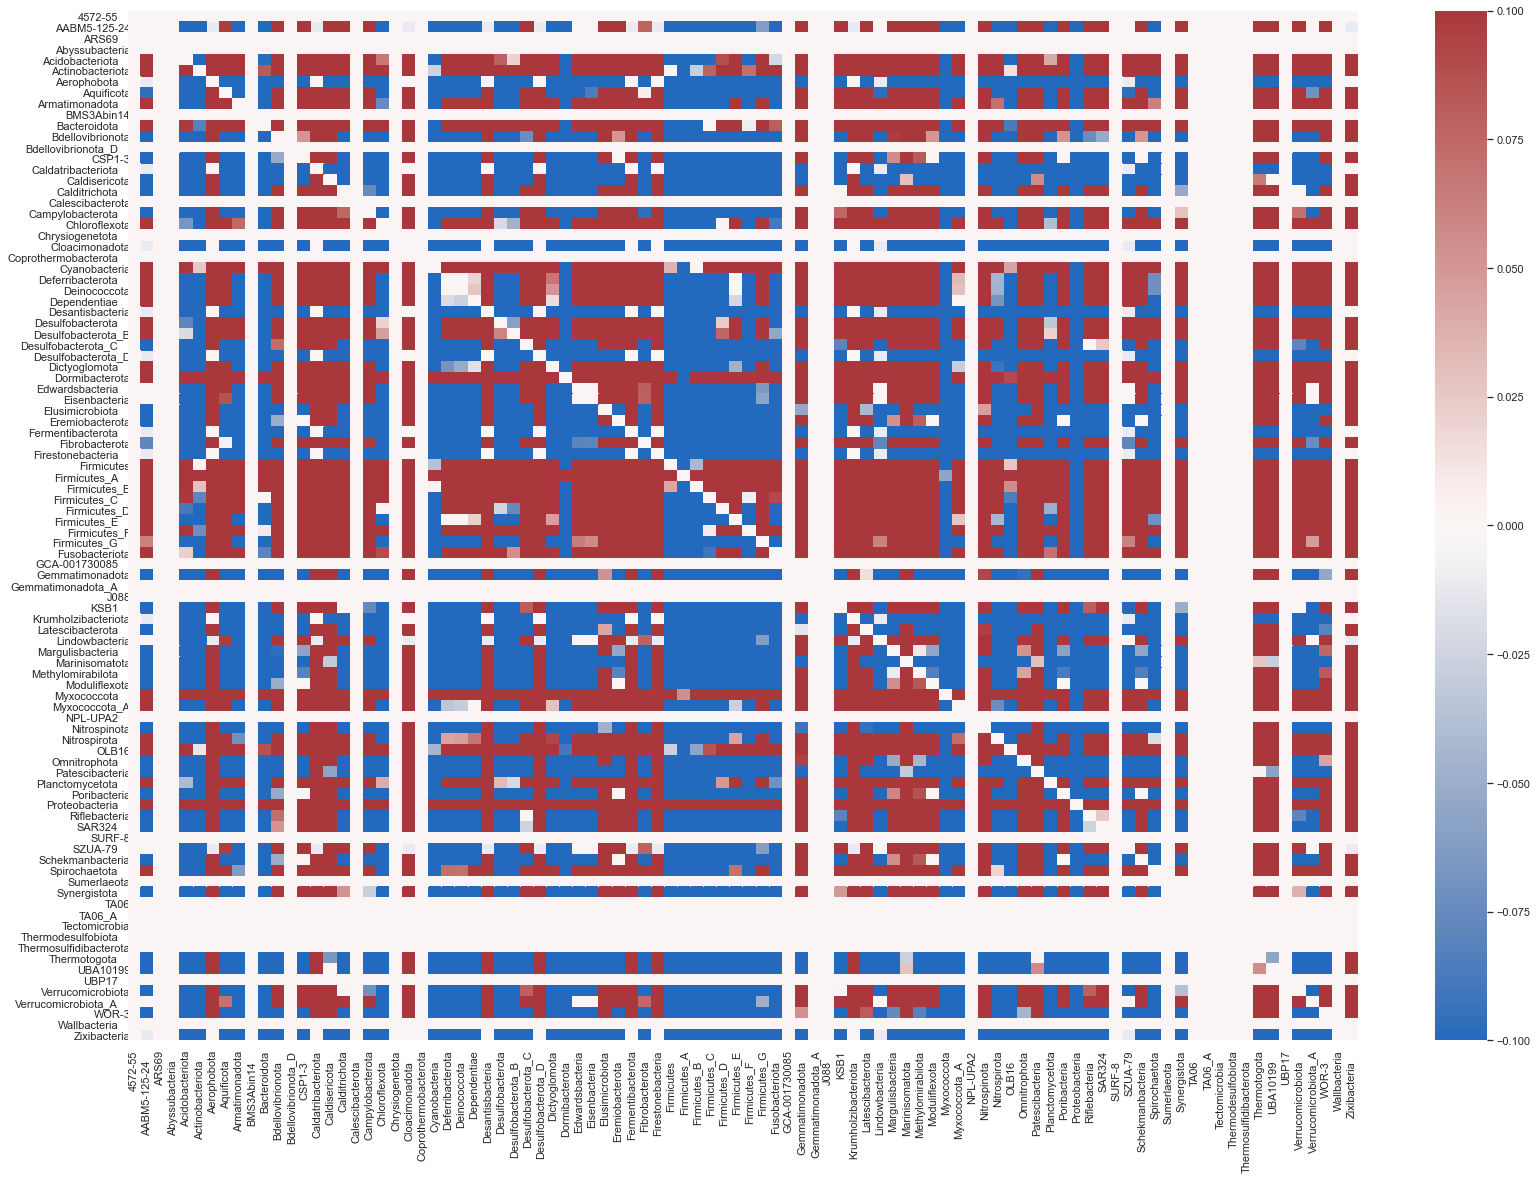

In [93]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
# coolwarm is also a good color_palette
sns.heatmap(cohend,  cmap=sns.color_palette("vlag", as_cmap=True), ax=ax, xticklabels=1, yticklabels=1)

lx = ax.xaxis.get_majorticklabels()
for alab in lx[1::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

ly = ax.yaxis.get_majorticklabels()
for alab in ly[1::2]:
    x, y = alab.get_position()
    alab.set_position((x+0.01, y))
    

plt.tight_layout()

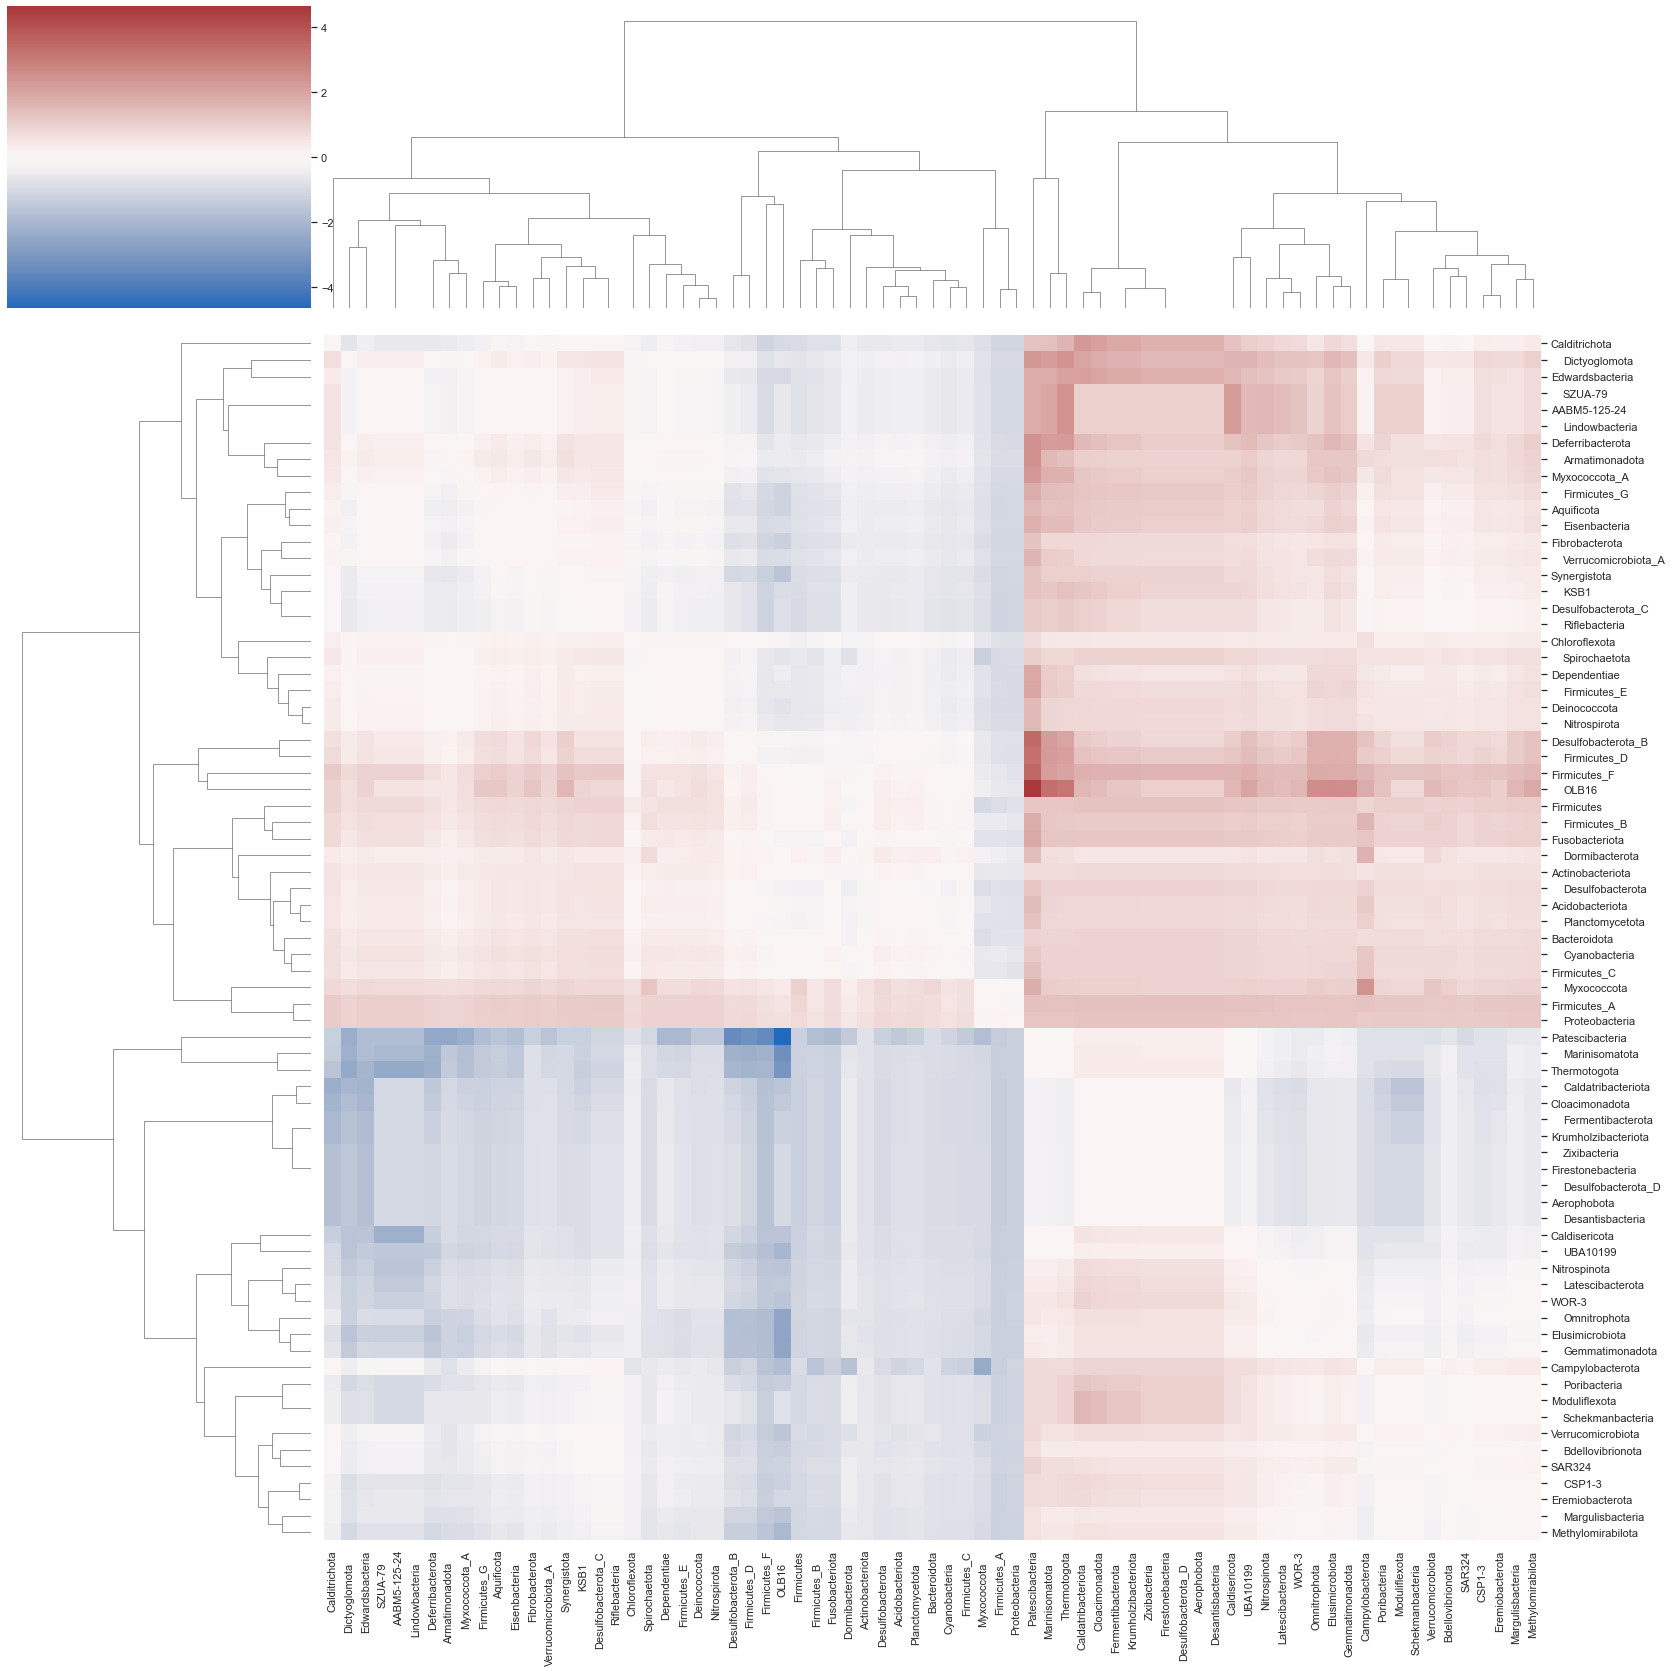

In [91]:
#fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))

# vlag is also a good color_palette
# coolwarm is also a good color_palette
# sns.heatmap(cohend,  cmap=sns.color_palette("vlag", as_cmap=True), ax=ax, xticklabels=1, yticklabels=1)
sns.set_theme(color_codes=True)
ax = sns.clustermap(
    cohenclean, 
    cmap=sns.color_palette("vlag", as_cmap=True),
    figsize=(23.4, 23.4),
)

"""
# get the tick labels and change some parameters about them.
xticks_loc = ax.get_xticklabels()
lx = ax.set_xticklabels(xticks_loc, fontsize=10)
# use this to hide every other tick
#[x.set_visible(False) for x in lx[::2]]

yticks_loc = ax.get_yticklabels()
ly = ax.set_yticklabels(yticks_loc, fontsize=10)
# use this to hide every other tick
#[y.set_visible(False) for y in ly[1::2]]


# add a slight offset for every other x tick label
for alab in lx[1::4]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# add a slight offset for every other y tick label
for alab in ly[2::4]:
    x, y = alab.get_position()
    alab.set_position((x-0.01, y))


"""

# plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=45)

lx = ax.ax_heatmap.xaxis.get_majorticklabels()
for alab in lx[1::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

ly = ax.ax_heatmap.yaxis.get_majorticklabels()
for alab in ly[1::2]:
    x, y = alab.get_position()
    alab.set_position((x+0.01, y))
    

plt.tight_layout()
plt.savefig('images/cohen_clustmap.png')
plt.savefig('images/cohen_clustmap.svg')

## Create a distance based on taxonomy

In [ ]:
gtdbex

In [ ]:
phyla = sorted(pd.unique(cvtax['phylum']))
phyladist = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    phyladist[p] = pd.to_numeric(phyladist[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]

